In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
!pip install --quiet dtaidistance

import logging

logging.disable(logging.CRITICAL)
plt.rcParams["figure.figsize"] = (20,8)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.5 MB/s eta 0:00:00


In [3]:
from google.colab import files
import io
import pandas as pd

# 1) Upload any files
print("Upload your full_features CSV and/or Excel:")
uploaded = files.upload()

# 2) Load the ones that have “full_features” in their filename
df_csv = None
df_xlsx = None

for fname, content in uploaded.items():
    lname = fname.lower()
    if "full_features" in lname:
        if lname.endswith(".csv"):
            df_csv = pd.read_csv(
                io.BytesIO(content),
                index_col=0,
                parse_dates=True
            )
            print(f"Loaded CSV into df_csv from {fname}")
        elif lname.endswith((".xls", ".xlsx")):
            df_xlsx = pd.read_excel(
                io.BytesIO(content),
                sheet_name=0,
                index_col=0,
                parse_dates=True
            )
            print(f"Loaded Excel into df_xlsx from {fname}")

# 3) Now df_csv and/or df_xlsx hold your DataFrame(s)
# Example check:
if df_csv is not None:
    print("CSV shape:", df_csv.shape)
    display(df_csv.head())
if df_xlsx is not None:
    print("Excel shape:", df_xlsx.shape)
    display(df_xlsx.head())



Upload your full_features CSV and/or Excel:


Saving dottenijs_full_features.csv to dottenijs_full_features.csv
Loaded CSV into df_csv from dottenijs_full_features.csv
CSV shape: (18029, 98)


,Load,hour,Day_of_week,Day_of_year,month,year,week_of_year,season,is_weekend,hour_sin,...,Exogenous_5_shifted_48,Exogenous_3_shifted_24,Exogenous_4_shifted_24,Exogenous_5_shifted_24,Relation_Hour_Weekday,shift_1,shift_2,temperature,temperature_lag48,temperature_lag54
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-15 00:00:00,1372.0,0,6,15,1,2023,2,2,1,0.000000,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2023-01-15 01:00:00,1520.0,1,6,15,1,2023,2,2,1,0.258819,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2023-01-15 02:00:00,1472.0,2,6,15,1,2023,2,2,1,0.500000,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2023-01-15 03:00:00,1408.0,3,6,15,1,2023,2,2,1,0.707107,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN
2023-01-15 04:00:00,1502.0,4,6,15,1,2023,2,2,1,0.866025,...,0.0,0.0,0.0,0.0,2,0,1,NaN,NaN,NaN


In [4]:
def mean_absolute_percentage_error(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)
    # Calculate MAPE (%) – add a small epsilon to avoid division by zero if needed
    return np.mean(np.abs((actual - pred) / (actual + 1e-8))) * 100

def directional_mean_accuracy(actual, pred):
    actual = np.array(actual)
    pred   = np.array(pred)
    # Calculate the sign of changes for actual and predicted
    actual_direction = np.sign(actual[1:] - actual[:-1])
    pred_direction   = np.sign(pred[1:] - pred[:-1])
    # Compare directions and compute accuracy as a percentage
    correct_direction = (actual_direction == pred_direction)
    return np.mean(correct_direction) * 100


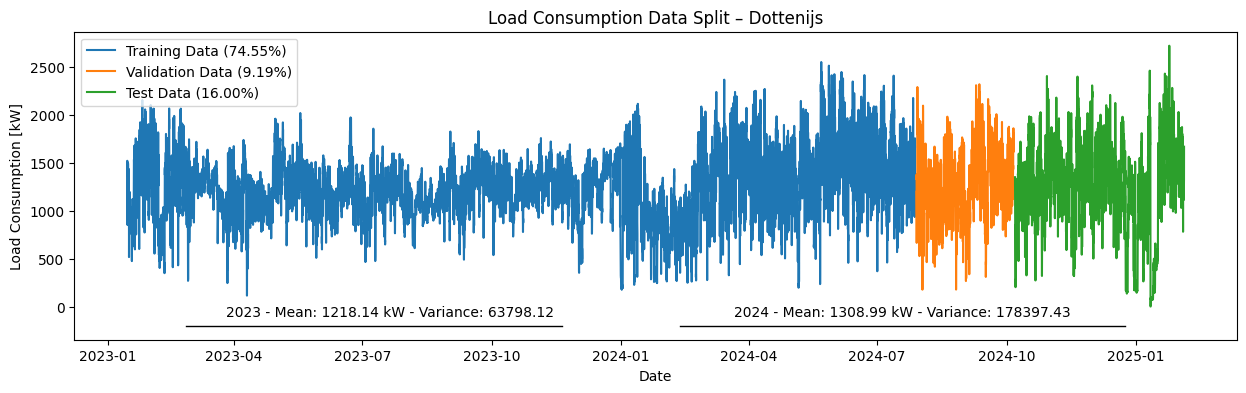

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_csv

# --- 1. Make sure your index is datetime ---
df.index = pd.to_datetime(df.index)

# --- 2. Define your “cut‐over” dates ---
# Validation starts on 29 July 2024
val_start = pd.to_datetime("2024-07-29")
# Test starts on 07 October 2024
test_start = pd.to_datetime("2024-10-07")

# --- 3. Slice by date (and .copy() to avoid SettingWithCopyWarnings) ---
train_data = df.loc[: val_start - pd.Timedelta(days=1)].copy()
val_data   = df.loc[val_start : test_start - pd.Timedelta(days=1)].copy()
test_data  = df.loc[test_start :].copy()

# --- 4. Compute actual percentages of the full dataset ---
total = len(df)
train_pct = len(train_data) / total * 100
val_pct   = len(val_data)   / total * 100
test_pct  = len(test_data)  / total * 100

# --- 5. Plot with percentages in the legend ---
plt.figure(figsize=(15, 4))
plt.plot(train_data.index, train_data['Load'],
         label=f'Training Data ({train_pct:.2f}%)')
plt.plot(val_data.index, val_data['Load'],
         label=f'Validation Data ({val_pct:.2f}%)')
plt.plot(test_data.index, test_data['Load'],
         label=f'Test Data ({test_pct:.2f}%)')

plt.title("Load Consumption Data Split – Dottenijs")
plt.xlabel("Date")
plt.ylabel("Load Consumption [kW]")
plt.legend()

data_2023 = df.loc['2023']
data_2024 = df.drop(data_2023.index)  # Remove 2023 data

data_2023
data_2024

# Adding brackets with text
plt.text(data_2023.index[int(len(data_2023)*0.2)], -100, '2023 - Mean: {:.2f} kW - Variance: {:.2f}'.format(data_2023['Load'].mean(), data_2023['Load'].var()), fontsize=10)
plt.text(data_2024.index[int(len(data_2024)*0.2)], -100, '2024 - Mean: {:.2f} kW - Variance: {:.2f}'.format(data_2024['Load'].mean(), data_2024['Load'].var()), fontsize=10)

height_br = -200
# Brackets
plt.plot([data_2023.index[1000], data_2023.index[-1000]], [height_br, height_br], 'k', lw=1)
plt.plot([data_2024.index[1000], data_2024.index[-1000]], [height_br, height_br], 'k', lw=1)
# plt.legend(pos= "topleft")
plt.show()



DELETE

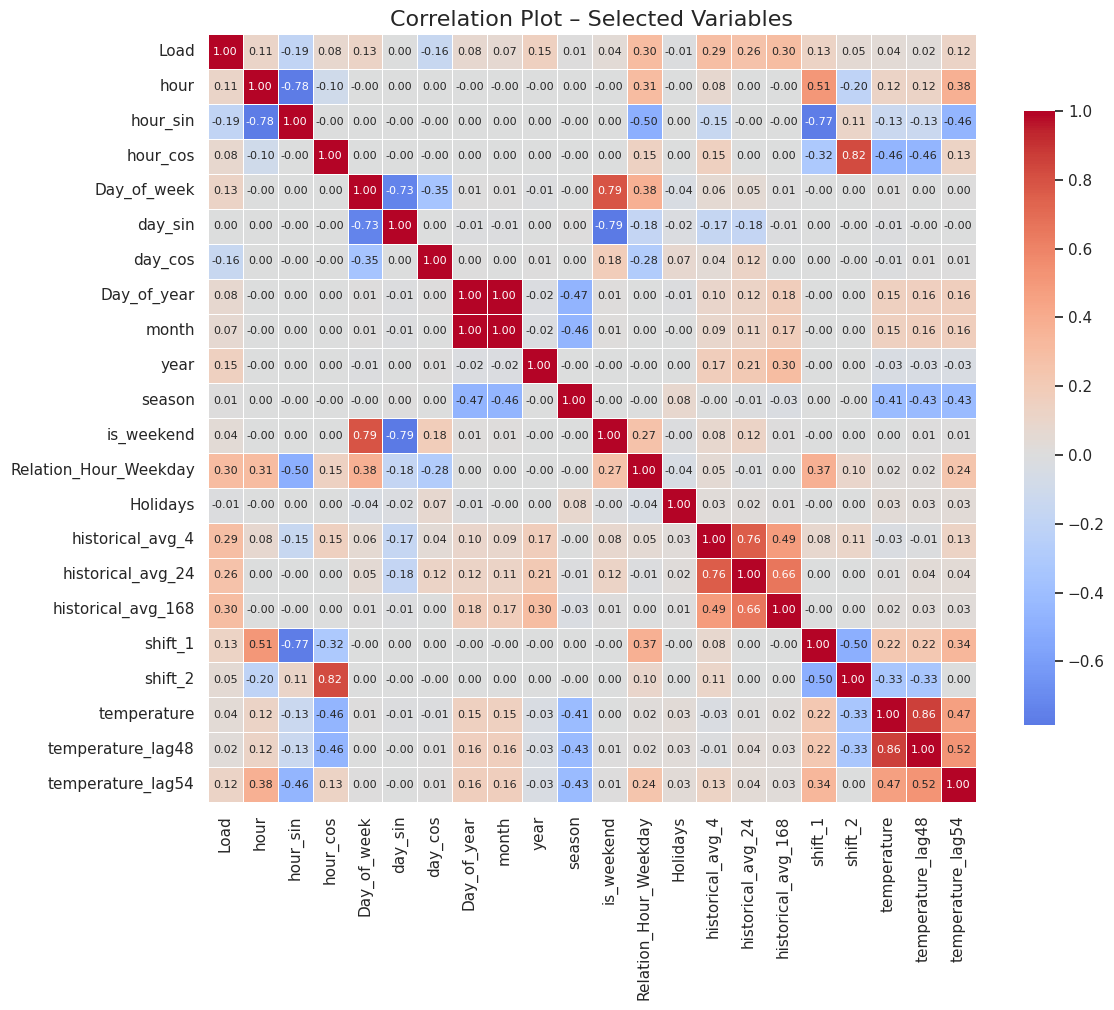

In [ ]:
# 1. Define the columns of interest
cols = ['Load',
    'hour', 'hour_sin', 'hour_cos', 'Day_of_week','day_sin', 'day_cos', 'Day_of_year', 'month', 'year', 'season',
    'is_weekend', 'Relation_Hour_Weekday', 'Holidays',
    'historical_avg_4', 'historical_avg_24', 'historical_avg_168',
    'shift_1', 'shift_2',
    'temperature', 'temperature_lag48', 'temperature_lag54'
]

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Subset and drop rows with missing values
df_selected = data_short[cols].dropna()

# df_selected = data_short[selected_columns].copy()
corr_matrix = df_selected.corr()

# Plot
plt.figure(figsize=(12, 10))
sns.set(style="white")

heatmap = sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}
)

plt.title("Correlation Plot – Selected Variables", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
weekly_cluster = data.groupby(['Day_of_week', 'hour'])['relatie_day_hout'].mean().unstack()
weekly_daily_avg = data.groupby(['Day_of_week'])['relatie_day_hout'].mean()
# Flatten the data into a sequence of 168 hours
weekly_avg_series = weekly_cluster.values.flatten()
# Create an x-axis with labels representing hours over 7 days
x_labels = np.arange(168)  # 7 days * 24 hours
days_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot the weekly pattern
plt.figure(figsize=(15,6))
plt.plot(x_labels, weekly_avg_series, linewidth=1, marker='o', label="Average Weekly Pattern (hourly intervals)")
# plt.plot(weekly_daily_avg.index*24, weekly_daily_avg.values, linewidth=1, marker='o', label="Average Weekly Pattern (daily intervals)")
# Formatting the x-axis
plt.xticks(ticks=np.arange(0, 168, 24), labels=days_labels)  # Mark each day

plt.xlabel('Day of the Week')
plt.ylabel('Average Power Consumption (kW)')
plt.title('Average Weekly Consumption Pattern - [2023 - 2024]')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
data_short = data_short.dropna()

TOT HIER

In [ ]:


# 3. Define cut‑over dates
val_start  = pd.to_datetime("2024-07-29")
test_start = pd.to_datetime("2024-10-07")

# 4. Slice into train/val/test on the truncated data
train_df = data_short.loc[: val_start - pd.Timedelta(days=1)].copy()
val_df   = data_short.loc[val_start : test_start - pd.Timedelta(days=1)].copy()
test_df  = data_short.loc[test_start :].copy()

# 5. Compute percentages relative to data_short
total_short = len(data_short)
train_pct   = len(train_df) / total_short * 100
val_pct     = len(val_df)   / total_short * 100
test_pct    = len(test_df)  / total_short * 100

# 6. Plot with updated legend
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['Load'],
         label=f'Training ({train_pct:.2f}%)')
plt.plot(val_data.index, val_data['Load'],
         label=f'Validation ({val_pct:.2f}%)')
plt.plot(test_data.index, test_data['Load'],
         label=f'Test ({test_pct:.2f}%)')

plt.title("Load Consumption Split on Data up to 24 Dec 2024")
plt.xlabel("Date")
plt.ylabel("Load Consumption [kW]")
plt.legend()
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Load'])
results.plot();

In [ ]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = ['hour','Day_of_week', 'year']


# ['Load','hour','weekday','lag_48','lag_168','roll_24_mean','roll_168_std'] - 277.8348214900517Test RMSE: 356.218406155885
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(train_df[feature_cols])
scaler_y.fit(train_df[["Load"]])

train_df_scaled =  pd.DataFrame(index=train_df.index)
val_df_scaled =  pd.DataFrame(index=val_df.index)
test_df_scaled =  pd.DataFrame(index=test_df.index)

train_df_scaled[feature_cols] = scaler_X.transform(train_df[feature_cols])
train_df_scaled['Load'] = scaler_y.transform(train_df[["Load"]])
val_df_scaled[feature_cols] = scaler_X.transform(val_df[feature_cols])
val_df_scaled['Load'] = scaler_y.transform(val_df[["Load"]])
test_df_scaled[feature_cols] = scaler_X.transform(test_df[feature_cols])
test_df_scaled['Load'] = scaler_y.transform(test_df[["Load"]])





#############################################
# 4. Create Sequences for LSTM
#############################################

def create_sequences(data,feature_cols, window_size, Prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - Prediction_time):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + Prediction_time]['Load'].values)
    return np.array(X), np.array(y)


# Define window size (lookback period)
window_size = 168 # 7
prediction_time = 24

# Create sequences
X_train, y_train = create_sequences(train_df_scaled,feature_cols, window_size, prediction_time)
X_val, y_val = create_sequences(val_df_scaled,feature_cols, window_size, prediction_time)
X_test, y_test = create_sequences(test_df_scaled,feature_cols, window_size, prediction_time)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


In [ ]:
#FIRST MODEL

#############################################
# 4. Build LSTM Model (Simple Version)
#############################################
model = Sequential()
model.add(LSTM(32, activation='tanh', return_sequences=True, input_shape=(window_size, len(feature_cols))))
model.add(Dropout(0.2))  # Regularization
# Second LSTM Layer
model.add(LSTM(16, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(24))  # Output layer with 96 neurons (96 timesteps)

# Compile Model with Quantile Loss (improves outlier handling)
def quantile_loss(q, y_true, y_pred):
    e = y_true - y_pred
    return tf.keras.backend.mean(tf.keras.backend.maximum(q * e, (q - 1) * e))

model.compile(optimizer='adam', loss='mse')
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val),
    # callbacks=[early_stopping, reduce_lr],
    callbacks=[early_stopping],
    shuffle=False
)

#############################################
# 5. Evaluate Model
#############################################
y_pred_scaled = model.predict(X_test)

# Invert scaling
y_test_inverted = scaler_y.inverse_transform(y_test)
y_pred_inverted = scaler_y.inverse_transform(y_pred_scaled)

# Compute evaluation metrics
mae = mean_absolute_error(y_test_inverted.flatten(), y_pred_inverted.flatten())
rmse = math.sqrt(mean_squared_error(y_test_inverted.flatten(), y_pred_inverted.flatten()))
print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")

#############################################
# 6. Plot Predictions vs Actual
#############################################
plt.figure(figsize=(15, 5))
plt.plot(y_test_inverted.flatten(), label='Actual')
plt.plot(y_pred_inverted.flatten(), label='Predicted', linestyle='dashed')
plt.title("LSTM Model - Actual vs Predicted Power Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

#############################################
# 7. Save Model for Future Use
#############################################
model.save("lstm_power_forecast.h5")
print("Model saved successfully!")


In [ ]:
# def create_sequences(df, feature_cols,lookback=144, gap=24, horizon=24,step=24, return_times=True):
#     """
#     Returns X, y, and (optionally) a list of pandas Timestamps
#     representing the first predicted hour of each sample.
#     """
#     X, y, times = [], [], []
#     n = len(df)

#     for i in range(lookback, n - gap - horizon + 1, step):
#         X.append(df.iloc[i-lookback : i][feature_cols].values)
#         y.append(df.iloc[i+gap : i+gap+horizon]['Load'].values)
#         if return_times:
#             times.append(df.index[i + gap])   # 00:00 of day T+1

#     if return_times:
#         return np.array(X), np.array(y), times
#     return np.array(X), np.array(y)

# X_test, y_test, t0_list = create_sequences(test_df_scaled, feature_cols,
#                                            lookback=148, gap=24, horizon=24,
#                                            step=24, return_times=True)


def create_sequences(data,feature_cols, window_size=168, Prediction_time=24,step=1, return_times=True):
    X, y, times = [], [], []
    for i in range(1,len(data) - window_size - Prediction_time, step):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size ][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + Prediction_time]['Load'].values)
        if return_times:
            times.append(data.index[i + window_size])   # 00:00 of day T+1
    if return_times:
        return np.array(X), np.array(y), times
    return np.array(X), np.array(y)

X_test, y_test, t0_list = create_sequences(test_df_scaled, feature_cols, window_size, prediction_time, step=24, return_times=True)


y_pred_scaled_2 = model.predict(X_test)
y_pred        = scaler_y.inverse_transform(y_pred_scaled_2)
y_true        = scaler_y.inverse_transform(y_test)

# Build a DataFrame whose rows are the 24‑h forecasts
records = []
for base_time, truth_row, pred_row in zip(t0_list, y_true, y_pred):
    hourly_index = pd.date_range(start=base_time, periods=24, freq='h')
    records.append(pd.DataFrame({
        'timestamp': hourly_index,
        'Load_true': truth_row,
        'Load_pred': pred_row
    }))

df_forecasts = pd.concat(records).set_index('timestamp')

# Compute evaluation metrics
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
rmse = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")

plt.figure(figsize=(15, 5))
plt.plot(test_df.index,test_df['Load'].values, label='Actual')
plt.plot(df_forecasts.index,df_forecasts['Load_pred'], label='Predicted', linestyle='dashed')
plt.title("LSTM Model - Actual vs Predicted Power Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test_inverted.flatten(), label='Actual')
plt.plot(y_pred_inverted.flatten(), label='Predicted', linestyle='dashed')
plt.title("LSTM Model - Actual vs Predicted Power Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Power Consumption")
plt.legend()
plt.show()

In [ ]:
data_short['unit_on'] = 300  # Default to ON

offset_value = 350

# Condition: both current and previous hour are < 250
off_condition = (
    (data_short['Load'] < offset_value) &
    (data_short['Load'].shift(1) < offset_value) &
    (data_short['Load'].shift(2) < offset_value) &
    (data_short['Load'].shift(3) < offset_value) &
    (data_short['Load'].shift(4) < offset_value)

)
data_short.loc[off_condition, 'unit_on'] = 0

# plt.figure(figsize=(12, 5))
# plt.plot(df.index, df['unit_on'].values)
# plt.show()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data_short.index,
    y=data_short['unit_on'].values,
    mode='lines',
    name='Training Data - 75%'
))

fig.add_trace(go.Scatter(
    x=data_short.index,
    y=data_short['Load'],
    mode='lines',
    name='Validation Data - 10%'
))


In [ ]:
!install optuna 3.4
import numpy as np, pandas as pd, math, gc, optuna, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

feature_cols = ['lag_24', 'hour','weekday', 'year']

def create_sequences(data,feature_cols, window_size, prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_time):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + prediction_time]['Load'].values)
    return np.array(X), np.array(y)

from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Multiply, Softmax, Lambda
)
import keras.ops as K   # new in Keras 3

def build_model(trial, n_features, horizon):
    n_layers   = trial.suggest_int("n_layers", 1, 3)
    base_units = trial.suggest_categorical("base_units", [32, 64, 128, 256])
    dropout    = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    rec_dp     = trial.suggest_float("rec_dropout", 0.0, 0.3, step=0.1)
    l2_reg     = l2(trial.suggest_float("l2", 1e-6, 1e-3, log=True))
    use_attn   = trial.suggest_categorical("use_attention", [True, False])

    x_in = Input(shape=(None, n_features))
    x = x_in
    for i in range(n_layers):
        return_seq = (i < n_layers-1) or use_attn
        units = base_units // (2**i)
        x = LSTM(units,
                 return_sequences=return_seq,
                 dropout=dropout,
                 recurrent_dropout=rec_dp,
                 kernel_regularizer=l2_reg)(x)

    if use_attn:
        # ---- Keras‑safe feature‑wise attention ----
        attn = Dense(1, activation="tanh")(x)          # (B,T,1)
        attn = Softmax(axis=1)(attn)                   # (B,T,1)
        x = Multiply()([x, attn])                      # (B,T,U) weighted
        x = Lambda(lambda t: K.sum(t, axis=1))(x)      # (B,U)
    else:
        if len(x.shape) == 3:                          # (B,T,U)
            x = Lambda(lambda t: t[:, -1, :])(x)       # last‑step pooling

    x = Dense(base_units // 4, activation="relu")(x)
    out = Dense(horizon)(x)

    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    model = tf.keras.Model(x_in, out)
    model.compile(optimizer=Adam(lr), loss="mse")
    return model

# ------------------------------------------------------------
# 3. OPTUNA OBJECTIVE
# ------------------------------------------------------------
def objective(trial):
    lookback = trial.suggest_categorical("lookback", [24, 168, 336, 720])
    stride   = trial.suggest_categorical("stride_train", [1, 3])

    X_tr, y_tr = create_sequences(train_df_scaled,feature_cols, window_size = lookback, prediction_time=24)
    X_vl, y_vl = create_sequences(val_df_scaled,feature_cols, window_size= lookback, prediction_time =24)

    model = build_model(trial, n_features=X_tr.shape[2], horizon=24)
    cb_es = tf.keras.callbacks.EarlyStopping(patience=8,
                                             monitor="val_loss",
                                             restore_best_weights=True)
    cb_pr = optuna.integration.TFKerasPruningCallback(trial, "val_loss")

    model.fit(X_tr, y_tr,
              validation_data=(X_vl, y_vl),
              epochs=60,
              batch_size=trial.suggest_categorical("batch_size", [32, 64, 128]),
              callbacks=[cb_es, cb_pr],
              verbose=0)

    y_pred = scaler_y.inverse_transform(model.predict(X_vl))
    y_true = scaler_y.inverse_transform(y_vl)
    rmse = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))

    tf.keras.backend.clear_session(); gc.collect()
    return rmse

# ------------------------------------------------------------
# 4. RUN THE SEARCH
# ------------------------------------------------------------
study = optuna.create_study(direction="minimize",
                            pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best RMSE  :", study.best_value)
print("Best params:", study.best_params)

# ------------------------------------------------------------
# 5. RETRAIN FINAL MODEL  (train + val)
# ------------------------------------------------------------
best = study.best_params
lookback = best["lookback"]

best_trial = study.best_trial
print(best_trial.number)        # trial index
print(best_trial.params)        # same dict as best_params
print(best_trial.user_attrs)    # any custom info you logged
print(best_trial.duration)      # how long that trial ran


X_train_full, y_train_full = create_sequences(
    pd.concat([train_df_scaled, val_df_scaled]), feature_cols,
    lookback=lookback, gap=24, horizon=24, step=best["stride_train"])

final_model = build_model(optuna.trial.FixedTrial(best),
                          n_features=X_train_full.shape[2],
                          horizon=24)
cb_es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

final_model.fit(X_train_full, y_train_full,
                epochs=80,
                batch_size=best["batch_size"],
                callbacks=[cb_es],
                verbose=1)

final_model.save("best_lstm_dayahead.h5")

# ------------------------------------------------------------
# 6. TEST‑SET EVALUATION
# ------------------------------------------------------------
X_test, y_test, t0_list = create_sequences(
    test_scaled, feature_cols,
    lookback=lookback, gap=24, horizon=24, step=24, return_times=True)

y_pred_scaled = final_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

rmse = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
mae  = mean_absolute_error(y_true.flatten(), y_pred.flatten())
print(f"TEST  RMSE : {rmse:.2f} kW")
print(f"TEST  MAE  : {mae:.2f} kW")

# ------------------------------------------------------------
# 7. BUILD A FORECAST DATAFRAME FOR PLOTS
# ------------------------------------------------------------
records = []
for base_time, y_t, y_p in zip(t0_list, y_true, y_pred):
    idx = pd.date_range(start=base_time, periods=24, freq='H')
    records.append(pd.DataFrame({"timestamp": idx,
                                 "Load_true": y_t,
                                 "Load_pred": y_p}))
df_fore = pd.concat(records).set_index("timestamp")

# plot one random day
sample_day = df_fore.index.normalize().unique()[0]
df_day = df_fore.loc[str(sample_day)]

plt.figure(figsize=(10,4))
plt.plot(df_day.index, df_day["Load_true"], label="Actual")
plt.plot(df_day.index, df_day["Load_pred"], "--", label="Predicted")
plt.title(f"Day‑ahead forecast – {sample_day.date()}")
plt.ylabel("Load [kW]"); plt.legend(); plt.show()

# **HYPER PARAMTER SCALING**

In [ ]:
# STEP ➊ — remove any pre‑installed Ray
!pip uninstall -y -q ray

# STEP ➋ — install the full ML bundle (includes Tune & AIR)
!pip install -q -U "ray[data,train,tune,serve]>=2.9.0"


In [ ]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = ['lag_24', 'hour','weekday', 'year']


# ['Load','hour','weekday','lag_48','lag_168','roll_24_mean','roll_168_std'] - 277.8348214900517Test RMSE: 356.218406155885
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_X.fit(train_df[feature_cols])
scaler_y.fit(train_df[["Load"]])

train_df_scaled =  pd.DataFrame(index=train_df.index)
val_df_scaled =  pd.DataFrame(index=val_df.index)
test_df_scaled =  pd.DataFrame(index=test_df.index)

train_df_scaled[feature_cols] = scaler_X.transform(train_df[feature_cols])
train_df_scaled['Load'] = scaler_y.transform(train_df[["Load"]])
val_df_scaled[feature_cols] = scaler_X.transform(val_df[feature_cols])
val_df_scaled['Load'] = scaler_y.transform(val_df[["Load"]])
test_df_scaled[feature_cols] = scaler_X.transform(test_df[feature_cols])
test_df_scaled['Load'] = scaler_y.transform(test_df[["Load"]])





#############################################
# 4. Create Sequences for LSTM
#############################################

def create_sequences(data,feature_cols, window_size, Prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - Prediction_time):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + Prediction_time]['Load'].values)
    return np.array(X), np.array(y)


# Define window size (lookback period)
window_size = 48 # 7
prediction_time = 24

# Create sequences
X_train, y_train = create_sequences(train_df_scaled,feature_cols, window_size, prediction_time)
X_val, y_val = create_sequences(val_df_scaled,feature_cols, window_size, prediction_time)
X_test, y_test = create_sequences(test_df_scaled,feature_cols, window_size, prediction_time)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

# --- 1. Load & preprocess your data here ---
# assume train_scaled, val_scaled are DataFrames with feature_cols + 'Load'
# and scaler_y is a fitted MinMaxScaler for 'Load'


# --- 2. The trainable function ---
def train_lstm(config):
    # build the model according to `config`
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = inputs
    for i in range(config["num_layers"]):
        return_seq = (i < config["num_layers"] - 1)
        x = LSTM(config["units"] // (2**i),
                 return_sequences=return_seq,
                 dropout=config["dropout"])(x)
    x = Dense(config["dense_units"], activation="relu")(x)
    outputs = Dense(y_train.shape[1])(x)
    model = Model(inputs, outputs)

    opt = Adam(learning_rate=config["lr"])
    model.compile(loss="mse", optimizer=opt)

    # fit
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=config["batch_size"],
        epochs=config["epochs"],
        verbose=0
    )
    # report the best validation loss to Tune
    tune.report(val_loss = min(history.history["val_loss"]))

# --- 3. Define search space + scheduler + search alg ---
search_space = {
    "num_layers":   tune.choice([1, 2, 3]),
    "units":        tune.choice([64, 128, 256]),
    "dropout":      tune.uniform(0.0, 0.2),
    "dense_units":  tune.choice([16, 32, 64]),
    "lr":           tune.loguniform(1e-4, 1e-2),
    "batch_size":   tune.choice([32, 64, 128]),
    "epochs":       tune.choice([20, 40, 80])
}

scheduler = ASHAScheduler(
    metric="val_loss", mode="min",
    max_t=80, grace_period=5, reduction_factor=2
)

# you can choose HyperOpt, BayesOpt, or default Random:
algo = HyperOptSearch(metric="val_loss", mode="min")

# --- 4. Run the tuning job ---
analysis = tune.run(
    train_lstm,
    config=search_space,
    num_samples=20,
    scheduler=scheduler,
    search_alg=algo,
    resources_per_trial={"cpu":2, "gpu":1},  # adjust to your Colab/GPU availability
    local_dir="ray_results",
    name="lstm_hpo"
)

# --- 5. Fetch the best config & retrain on train+val ---
best_config = analysis.get_best_config(metric="val_loss", mode="min")
print("Best hyperparameters:", best_config)

# build & fit final model on train+val, then evaluate on test as before...


In [ ]:
# 1) (One‑time) install Ray Tune in your notebook:
# !pip install -q ray[tune]
# !pip install -q ray[tune]

from ray import tune
from ray.tune.integration.keras import TuneReportCallback

import ray
ray.shutdown()                    # clean up any prior Ray instance
ray.init(num_cpus=2, ignore_reinit_error=True)

from ray.tune.search.basic_variant import BasicVariantGenerator
from ray.tune import CLIReporter

# 2) Your train function that builds, trains and reports RMSE:
def train_lstm(config):
    # Build your Keras LSTM using config["n_layers"], config["units"], etc.
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = inputs
    for _ in range(config["n_layers"] - 1):
        x = tf.keras.layers.LSTM(config["units"],
                                 return_sequences=True,
                                 dropout=config["dropout"])(x)
    x = tf.keras.layers.LSTM(config["units"],
                             return_sequences=False,
                             dropout=config["dropout"])(x)
    outputs = tf.keras.layers.Dense(y_train.shape[1])(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(config["lr"]),
                  loss="mse")

    # Fit quietly; the reporter will show progress
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=config["epochs"],
              batch_size=config["batch_size"],
              callbacks=[TuneCallback()],
              verbose=0)

    # Evaluate on validation set
    preds = model.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val.flatten(), preds.flatten()))

    tune.report({"val_rmse": rmse})


# 3) Define the search space for random sampling
search_space = {
    "n_layers":   tune.randint(1, 4),            # 1–3 LSTM layers
    "units":      tune.choice([16,32, 64]),
    "dropout":    tune.uniform(0, 0.3),
    "batch_size": tune.choice([32, 64, 128]),
    "lr":         tune.loguniform(1e-4, 5e-3),
    "epochs":     tune.randint(20, 51)           # 20–50 epochs
}

# 4) Set up a CLIReporter to see each trial’s progress
reporter = CLIReporter(metric_columns=["val_rmse", "training_iteration"])

# 5) Launch 20 random trials with BasicVariantGenerator
analysis = tune.run(
    train_lstm,
    config=search_space,
    num_samples=20,                          # 20 random draws
    search_alg=BasicVariantGenerator(),      # explicit random sampler
    progress_reporter=reporter,
    metric="val_rmse",                       # we minimize this
    mode="min",
    resources_per_trial={"cpu": 1, "gpu": 0},
    verbose=1
)

# 6) When done, print out the best hyper‑parameters found
print("Best hyperparameters found:", analysis.best_config)


In [ ]:
!sed -n '1,200p' /tmp/ray/session_2025-04-20_12-03-16_628847_155/artifacts/2025-04-20_12-03-25/train_lstm_2025-04-20_12-03-25/driver_artifacts/train_lstm_76808_00005_5_batch_size=64,dropout=0.2650,epochs=22,lr=0.0006,n_layers=3,units=16_2025-04-20_12-03-25/error.txt


In [ ]:
# 1) (One‑time) install Ray Tune in your notebook:
# !pip install -q ray[tune]
# !pip install -q ray[tune]

from ray import tune
from ray.air.integrations.keras import TuneCallback

import ray
ray.shutdown()                    # clean up any prior Ray instance
ray.init(num_cpus=2, ignore_reinit_error=True)

from ray.tune.search.basic_variant import BasicVariantGenerator
from ray.tune import CLIReporter

# 2) Your train function that builds, trains and reports RMSE:
def train_lstm(config):
    # Build your Keras LSTM using config["n_layers"], config["units"], etc.
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = inputs
    for _ in range(config["n_layers"] - 1):
        x = tf.keras.layers.LSTM(config["units"],
                                 return_sequences=True,
                                 dropout=config["dropout"])(x)
    x = tf.keras.layers.LSTM(config["units"],
                             return_sequences=False,
                             dropout=config["dropout"])(x)
    outputs = tf.keras.layers.Dense(y_train.shape[1])(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(config["lr"]),
                  loss="mse")

    # Fit quietly; the reporter will show progress
    model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs=config["epochs"],
              batch_size=config["batch_size"],
              callbacks=[TuneCallback()],
              verbose=0)

    # Evaluate on validation set
    preds = model.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val.flatten(), preds.flatten()))

    tune.report({"val_rmse": rmse})


# 3) Define the search space for random sampling
search_space = {
    "n_layers":   tune.randint(1, 4),            # 1–3 LSTM layers
    "units":      tune.choice([16,32, 64]),
    "dropout":    tune.uniform(0, 0.3),
    "batch_size": tune.choice([32, 64, 128]),
    "lr":         tune.loguniform(1e-4, 5e-3),
    "epochs":     tune.randint(20, 51)           # 20–50 epochs
}

# 4) Set up a CLIReporter to see each trial’s progress
reporter = CLIReporter(metric_columns=["val_rmse", "training_iteration"])

# 5) Launch 20 random trials with BasicVariantGenerator
analysis = tune.run(
    train_lstm,
    config=search_space,
    num_samples=20,                          # 20 random draws
    search_alg=BasicVariantGenerator(),      # explicit random sampler
    progress_reporter=reporter,
    metric="val_rmse",                       # we minimize this
    mode="min",
    resources_per_trial={"cpu": 1, "gpu": 0},
    verbose=1
)

# 6) When done, print out the best hyper‑parameters found
print("Best hyperparameters found:", analysis.best_config)


# **FOR LOOP**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf_all(series, load_col="Series", n_days=18):
    """
    Plot ACF and PACF of a time series using both manual Bartlett bands and statsmodels default method.

    Parameters:
        series (pd.Series): Hourly time series with datetime index.
        load_col (str): Label for title.
        n_days (int): Number of days of lags to show (e.g., 18 days = 432 lags).
    """
    assert isinstance(series, pd.Series), "Input must be a pandas Series."
    series_hourly = series.dropna()
    N = len(series_hourly)
    n_lags_hourly = n_days * 24

    acf_hourly = acf(series_hourly, nlags=n_lags_hourly, fft=True)
    pacf_hourly = pacf(series_hourly, nlags=n_lags_hourly, method='ywm')
    lags_hourly = np.arange(len(acf_hourly)) / 24.0  # convert hours to days

    # Bartlett SE for ACF
    se_acf = np.zeros_like(acf_hourly)
    for k in range(1, len(acf_hourly)):
        se_acf[k] = np.sqrt((1 + 2*np.sum(acf_hourly[1:k]**2)) / N)
    upper_acf = 1.96 * se_acf
    lower_acf = -upper_acf

    # Bartlett SE for PACF
    se_pacf = 1.0 / np.sqrt(N - np.arange(len(pacf_hourly)))
    upper_pacf = 1.96 * se_pacf
    lower_pacf = -upper_pacf

    # --- Manual ACF Plot ---
    plt.figure(figsize=(12, 6))
    plt.plot(lags_hourly, acf_hourly, label='ACF', color='blue', marker='o', markersize=3)
    plt.plot(lags_hourly, upper_acf, 'b--', label='±1.96·SE (Bartlett)')
    plt.plot(lags_hourly, lower_acf, 'b--')
    plt.axhline(0, linestyle='--', color='gray')
    plt.title(f"Autocorrelation Function (ACF) - Hourly data - {load_col}")
    plt.xlabel("Time lag (days)")
    plt.ylabel("Autocorrelation")
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Manual PACF Plot ---
    plt.figure(figsize=(12, 6))
    plt.plot(lags_hourly, pacf_hourly, label='PACF', color='red', marker='o', markersize=3)
    plt.plot(lags_hourly, upper_pacf, 'b--', label='±1.96·SE (Bartlett)')
    plt.plot(lags_hourly, lower_pacf, 'b--')
    plt.axhline(0, linestyle='--', color='gray')
    plt.title(f"Partial Autocorrelation Function (PACF) - Hourly data - {load_col}")
    plt.xlabel("Time lag (days)")
    plt.ylabel("Partial Autocorrelation")
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- Statsmodels built-in ACF/PACF Plot ---
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(series_hourly, ax=axes[0], lags=n_lags_hourly, alpha=0.05)
    axes[0].set_title(f"statsmodels ACF with 95% CI – {load_col}")
    axes[0].set_ylim(-0.4, 1.0)

    plot_pacf(series_hourly, ax=axes[1], lags=n_lags_hourly, alpha=0.05, method='ywm')
    axes[1].set_title(f"statsmodels PACF with 95% CI – {load_col}")
    axes[1].set_ylim(-0.4, 1.0)

    plt.tight_layout()
    plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
import os
import joblib
import math
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from dtaidistance import dtw


# ── EDIT THIS TO YOUR LOCAL WIN PATH ────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR  = "/content/drive/MyDrive/Thesis AI - vaheeden/saved_models"
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ─────────────────────────────────────────────────────────────────────

os.makedirs(PLOTS_DIR, exist_ok=True)

# --- your create_sequences ---
def create_sequences(data, feature_cols, window_size, gap, prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_time - gap +1):
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size + gap:i + window_size + gap + prediction_time]['Load'].values)
    return np.array(X), np.array(y)


def create_sequences_24_hour(data,feature_cols, window_size=168,gap=24, Prediction_time=24,step=1, return_times=True):
    X, y, times = [], [], []
    for i in range(0,len(data) - window_size - gap - Prediction_time+1+step, step):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size ][feature_cols].values)
        y.append(data.iloc[i + window_size + gap:i + window_size + gap + Prediction_time]['Load'].values)
        if return_times:
            times.append(data.index[i + window_size])   # 00:00 of day T+1
    print("Last forecast made for:", times[-1] + pd.Timedelta(hours=23))
    print("Last timestamp in dataset:", data.index[-1])

    if return_times:
        return np.array(X), np.array(y), times
    return np.array(X), np.array(y)

import plotly.graph_objects as go
import os




# --- LSTM builder ---
def build_lstm_model(window_size, n_features, prediction_time,
                     lstm_units=[64,32], dropout=0.2):
    optimizer = Adam(learning_rate=0.0002)
    m = Sequential([
        LSTM(lstm_units[0], activation='tanh', return_sequences=True,
             input_shape=(window_size, n_features)),
        Dropout(dropout),
        LSTM(lstm_units[1], activation='tanh', return_sequences=False),
        Dropout(dropout),
        Dense(prediction_time)
    ])
    m.compile(optimizer='adam', loss='mae')
    return m


import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dropout, Dense, Concatenate, Lambda, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# 3. Define cut‑over dates
val_start  = pd.to_datetime("2024-08-07")
test_start = pd.to_datetime("2024-10-07")

# 4. Slice into train/val/test on the truncated data
train_df = df_csv.loc[: val_start - pd.Timedelta(hours=1)].copy()
val_df   = df_csv.loc[val_start : test_start - pd.Timedelta(hours=1)].copy()
test_df  = df_csv.loc[test_start :].copy()


    # --- settings ---
window_size     = 144
prediction_time = 24
gap = 24

test_combinations= [ [ 'Load', 'roll_4_std', 'historical_avg_direct_4','hour_sin','hour_cos','day_sin','day_cos', 'year']]

results = []

# grab the final 7 days from train+val
warmup_val = pd.concat([train_df]).iloc[-window_size:]
warmup_test = pd.concat([train_df, val_df]).iloc[-window_size:]

# build an “extended” test set that starts window_size hours *before* test_start
val_extended = pd.concat([warmup_val, val_df])
test_extended = pd.concat([warmup_test, test_df])

for combo in test_combinations:
    feat_str = "_".join(combo)

    # Define groups
    features_to_scale = ['lag_24', 'lag_144', 'lag_312', 'roll_4_std', 'year', 'historical_avg_direct_4']
    features_pass = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos']


        # Fit scalers only on train set
    scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(train_df[features_to_scale])
    scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_df[['Load']])


    # helper to scale any df
    def scale_df(df):
      df_s = pd.DataFrame(index=df.index)
      # Scale numeric features
      df_s[features_to_scale] = scaler_X.transform(df[features_to_scale])
      # Pass through raw cyclical/binary features
      df_s[features_pass] = df[features_pass]
      # Scale target
      df_s["Load"] = scaler_y.transform(df[["Load"]])
      return df_s

    train_s = scale_df(train_df)
    val_s   = scale_df(val_df)
    test_s  = scale_df(test_extended)

    # 2) sequences
    X_tr, y_tr = create_sequences(train_s, combo, window_size,gap, prediction_time)
    X_val, y_val = create_sequences(val_s, combo, window_size,gap, prediction_time)
    X_te, y_te = create_sequences(test_s, combo, window_size,gap, prediction_time)


       # 3) build & train
    model = build_lstm_model(window_size, len(combo), prediction_time)
    # model = build_lstm_with_onoff(window_size, len(combo), prediction_time)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=50, batch_size=32,
        callbacks=[es],
        shuffle=False
    )

    # 4) evaluate
    y_pred_s   = model.predict(X_te)
    y_te_inv   = scaler_y.inverse_transform(y_te)
    y_pred_inv = scaler_y.inverse_transform(y_pred_s)

    mae  = mean_absolute_error(y_te_inv.flatten(), y_pred_inv.flatten())
    rmse = math.sqrt(mean_squared_error(y_te_inv.flatten(), y_pred_inv.flatten()))

    # 5) save model & scalers
    model_path    = os.path.join(MODELS_DIR,     f"lstm_{feat_str}_1fout.h5")
    scalerX_path  = os.path.join(MODELS_DIR,     f"scalerX_{feat_str}_1fout.pkl")
    scalerY_path  = os.path.join(MODELS_DIR,     f"scalery_{feat_str}_1fout.pkl")

    model.save(model_path)
    joblib.dump(scaler_X, scalerX_path)
    joblib.dump(scaler_y, scalerY_path)


    # 24 hour plot (more correct)
    X_test, y_test, t0_list = create_sequences_24_hour(test_s, combo, window_size, prediction_time, step=24, return_times=True)
    y_pred_scaled_2 = model.predict(X_test)
    y_pred        = scaler_y.inverse_transform(y_pred_scaled_2)
    y_true        = scaler_y.inverse_transform(y_test)
    # Build a DataFrame whose rows are the 24‑h forecasts
    records = []
    for base_time, truth_row, pred_row in zip(t0_list, y_true, y_pred):
        hourly_index = pd.date_range(start=base_time, periods=24, freq='h')
        records.append(pd.DataFrame({
            'timestamp': hourly_index,
            'Load_true': truth_row,
            'Load_pred': pred_row
        }))
    df_forecasts = pd.concat(records).set_index('timestamp')
    # Compute evaluation metrics
    mae_real = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse_real = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    dma_value  = directional_mean_accuracy(y_true.flatten(), y_pred.flatten())
    dtw_d = dtw.distance(y_true.flatten(), y_pred.flatten())

    # 6) plot Actual vs Predicted
    plt.figure(figsize=(15, 6))
    plt.plot(test_df.index,test_df['Load'].values, label='Actual')
    plt.plot(df_forecasts.index,df_forecasts['Load_pred'], label='Predicted', linestyle='dashed')
    plt.title(f"{feat_str}  →  MAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Load")
    plt.legend()
    plt.tight_layout()
    plot_path_real     = os.path.join(PLOTS_DIR,      f"plot_{feat_str}_real_1fout.png")
    plt.savefig(plot_path_real)
    plt.show()



    # 7) record result
    results.append({'features': combo, 'MAE_val': mae, 'RMSE_val': rmse,'MAE_test': mae_real, 'RMSE_test': rmse_real, 'DMA': dma_value, 'DTW': dtw_d })
    print(f"✔ [{feat_str}] saved model + plot  →  MAE_val: {mae:.3f}, RMSE_val: {rmse:.3f},  MAE_test: {mae_real:.3f}, RMSE_test: {rmse_real:.3f}, DMA: {dma_value:.2f}, DTW: {dtw_d:.2f}")

# final summary
results_df = pd.DataFrame(results).sort_values('MAE_val').reset_index(drop=True)
print("\nAll results:")
print(results_df)

best = results_df.iloc[0]
print(f"\nBest combo: {best['features']}  →  MAE_val: {best['MAE_val']:.3f}")

for i in features_pass:
  print(train_s[[i]].mean(), train_s[[i]].std())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1799 - val_loss: 0.1087
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1063 - val_loss: 0.1088
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1000 - val_loss: 0.1087
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0964 - val_loss: 0.1093
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0943 - val_loss: 0.1090
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0927 - val_loss: 0.1083
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0915 - val_loss: 0.1091
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0906 - val_loss: 0.1081
Epoch 9/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0891 - val_loss: 0.1077
Epoch 10/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0883 - val_loss: 0.1078
Epoch 11/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0877 - val_loss: 0.1066
Epoch 12/50
422/422 ━━━━━━━━━━━━━━━━━━

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (79,) + inhomogeneous part.

Last forecast made for: 2024-12-23 23:00:00
Last timestamp in dataset: 2024-12-24 23:00:00
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


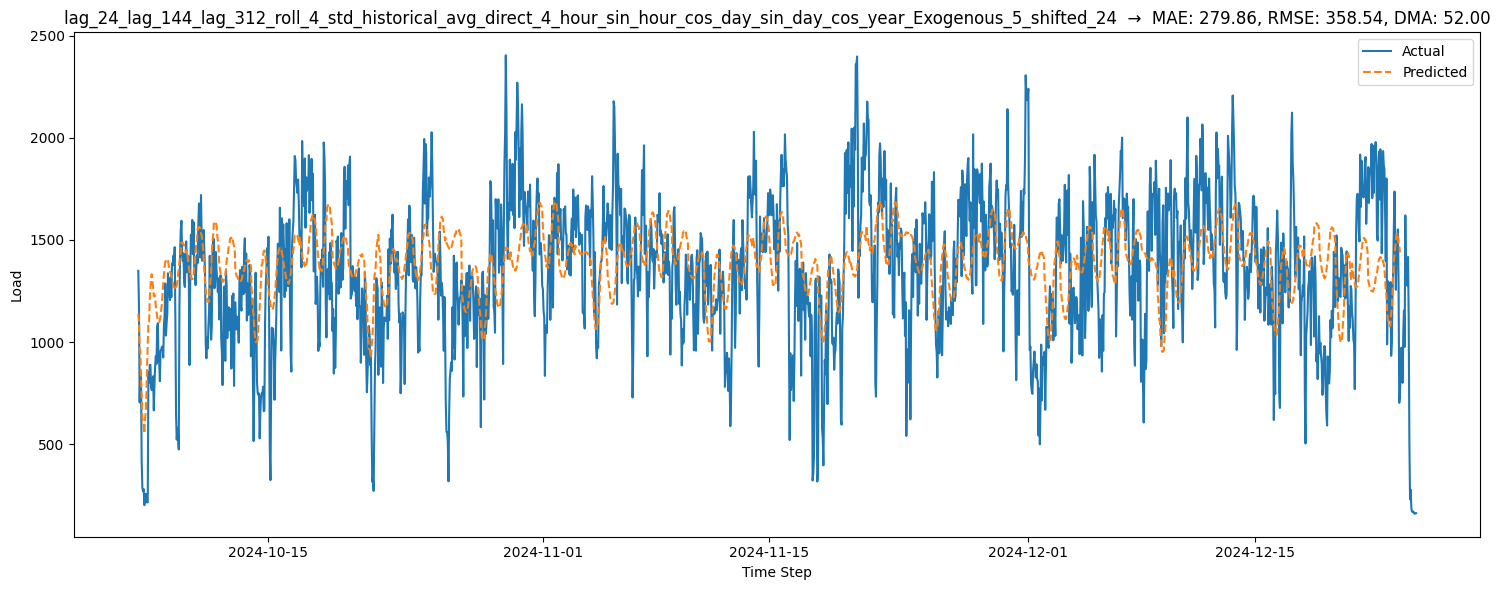

✔ [lag_24_lag_144_lag_312_roll_4_std_historical_avg_direct_4_hour_sin_hour_cos_day_sin_day_cos_year_Exogenous_5_shifted_24] saved model + plot  →  MAE_val: 255.694, RMSE_val: 323.296,  MAE_test: 279.863, RMSE_test: 358.543, DMA: 52.00, DTW: 9780.42

All results:
                                            features     MAE_val   RMSE_val  \
0  [lag_24, lag_144, lag_312, roll_4_std, histori...  255.693761  323.29641   
1  [lag_24, lag_144, lag_312, roll_4_std, histori...  255.693761  323.29641   

     MAE_test   RMSE_test        DMA          DTW  
0  257.109274  324.984812  52.031662  9099.928173  
1  279.863137  358.542779  52.004276  9780.415467  

Best combo: ['lag_24', 'lag_144', 'lag_312', 'roll_4_std', 'historical_avg_direct_4', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'year', 'Exogenous_5_shifted_24']  →  MAE_val: 255.694
hour_sin   -1.811417e-17
dtype: float64 hour_sin    0.707133
dtype: float64
hour_cos   -5.473205e-17
dtype: float64 hour_cos    0.707133
dtype: float64
day

In [ ]:
def create_sequences_24_hour(data,feature_cols, window_size=168,gap=24, Prediction_time=24,step=1, return_times=True):
    X, y, times = [], [], []
    for i in range(0, len(data) - window_size - gap - Prediction_time + 1 , step):
      X_window = data.iloc[i:i + window_size][feature_cols].values
      y_window = data.iloc[i + window_size + gap : i + window_size + gap + Prediction_time]['Load'].values

      # Skip incomplete final target windows
      if len(y_window) < Prediction_time:
          continue

      X.append(X_window)
      y.append(y_window)
      if return_times:
          times.append(data.index[i + window_size])
    print("Last forecast made for:", times[-1] + pd.Timedelta(hours=23))
    print("Last timestamp in dataset:", data.index[-1])

    if return_times:
        return np.array(X), np.array(y), times
    return np.array(X), np.array(y)

import plotly.graph_objects as go
import os

# 24 hour plot (more correct)
X_test, y_test, t0_list = create_sequences_24_hour(test_s, combo, window_size, prediction_time, step=24, return_times=True)
y_pred_scaled_2 = model.predict(X_test)
y_pred        = scaler_y.inverse_transform(y_pred_scaled_2)
y_true        = scaler_y.inverse_transform(y_test)
# Build a DataFrame whose rows are the 24‑h forecasts
records = []
for base_time, truth_row, pred_row in zip(t0_list, y_true, y_pred):
    hourly_index = pd.date_range(start=base_time, periods=24, freq='h')
    records.append(pd.DataFrame({
        'timestamp': hourly_index,
        'Load_true': truth_row,
        'Load_pred': pred_row
    }))
df_forecasts = pd.concat(records).set_index('timestamp')
# Compute evaluation metrics
mae_real = mean_absolute_error(y_true.flatten(), y_pred.flatten())
rmse_real = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
dma_value  = directional_mean_accuracy(y_true.flatten(), y_pred.flatten())
dtw_d = dtw.distance(y_true.flatten(), y_pred.flatten())

# 6) plot Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(test_df.index,test_df['Load'].values, label='Actual')
plt.plot(df_forecasts.index,df_forecasts['Load_pred'], label='Predicted', linestyle='dashed')
plt.title(f"{feat_str}  →  MAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}")
plt.xlabel("Time Step")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plot_path_real     = os.path.join(PLOTS_DIR,      f"plot_{feat_str}_real_1fout.png")
plt.savefig(plot_path_real)
plt.show()



# 7) record result
results.append({'features': combo, 'MAE_val': mae, 'RMSE_val': rmse,'MAE_test': mae_real, 'RMSE_test': rmse_real, 'DMA': dma_value, 'DTW': dtw_d })
print(f"✔ [{feat_str}] saved model + plot  →  MAE_val: {mae:.3f}, RMSE_val: {rmse:.3f},  MAE_test: {mae_real:.3f}, RMSE_test: {rmse_real:.3f}, DMA: {dma_value:.2f}, DTW: {dtw_d:.2f}")

# final summary
results_df = pd.DataFrame(results).sort_values('MAE_val').reset_index(drop=True)
print("\nAll results:")
print(results_df)

best = results_df.iloc[0]
print(f"\nBest combo: {best['features']}  →  MAE_val: {best['MAE_val']:.3f}")

for i in features_pass:
  print(train_s[[i]].mean(), train_s[[i]].std())


In [ ]:
df_forecasts.index

DatetimeIndex(['2024-10-07 00:00:00', '2024-10-07 01:00:00',
               '2024-10-07 02:00:00', '2024-10-07 03:00:00',
               '2024-10-07 04:00:00', '2024-10-07 05:00:00',
               '2024-10-07 06:00:00', '2024-10-07 07:00:00',
               '2024-10-07 08:00:00', '2024-10-07 09:00:00',
               ...
               '2024-12-23 14:00:00', '2024-12-23 15:00:00',
               '2024-12-23 16:00:00', '2024-12-23 17:00:00',
               '2024-12-23 18:00:00', '2024-12-23 19:00:00',
               '2024-12-23 20:00:00', '2024-12-23 21:00:00',
               '2024-12-23 22:00:00', '2024-12-23 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=1872, freq=None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0653 - val_loss: 0.0176
Epoch 2/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0188 - val_loss: 0.0175
Epoch 3/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0166 - val_loss: 0.0174
Epoch 4/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0156 - val_loss: 0.0174
Epoch 5/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0149 - val_loss: 0.0172
Epoch 6/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.0143 - val_loss: 0.0172
Epoch 7/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0140 - val_loss: 0.0169
Epoch 8/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0135 - val_loss: 0.0168
Epoch 9/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0134 - val_loss: 0.0167
Epoch 10/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0131 - val_loss: 0.0166
Epoch 11/50
417/417 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0129 - val_loss: 0.0164
Epoch 12/50
417/417 ━━━━━━━━━━━

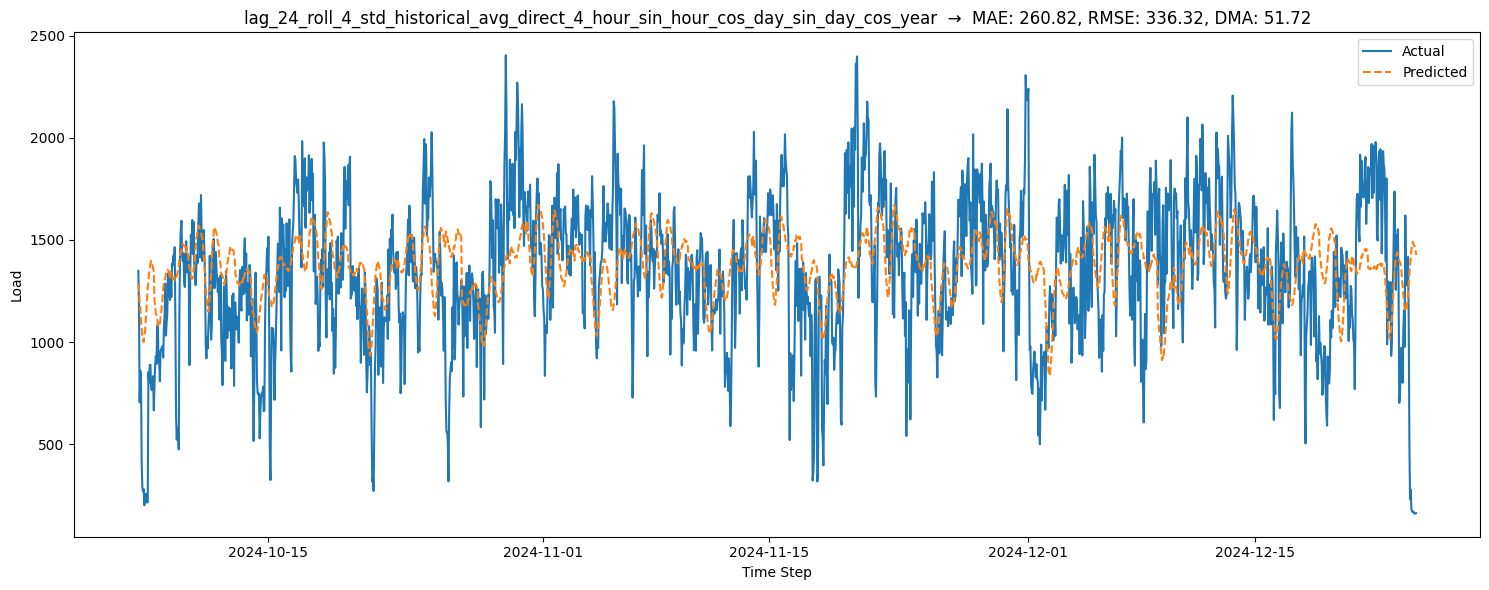

✔ [lag_24_roll_4_std_historical_avg_direct_4_hour_sin_hour_cos_day_sin_day_cos_year] saved model + plot  →  MAE_val: 256.254, RMSE_val: 325.945,  MAE_test: 260.825, RMSE_test: 336.321, DMA: 51.72, DTW: 10126.21

All results:
                                            features     MAE_val    RMSE_val  \
0  [lag_24, roll_4_std, historical_avg_direct_4, ...  256.253702  325.944998   

    MAE_test   RMSE_test       DMA           DTW  
0  260.82488  336.320682  51.71504  10126.209206  

Best combo: ['lag_24', 'roll_4_std', 'historical_avg_direct_4', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'year']  →  MAE_val: 256.254
hour_sin   -1.811417e-17
dtype: float64 hour_sin    0.707133
dtype: float64
hour_cos   -5.473205e-17
dtype: float64 hour_cos    0.707133
dtype: float64
day_sin   -2.207461e-17
dtype: float64 day_sin    0.706788
dtype: float64
day_cos    0.003942
dtype: float64 day_cos    0.707466
dtype: float64
Exogenous_5_shifted_24    0.007164
dtype: float64 Exogenous_5_shifted_24    

In [17]:
import os
import joblib
import math
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from dtaidistance import dtw


# ── EDIT THIS TO YOUR LOCAL WIN PATH ────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR  = "/content/drive/MyDrive/Thesis AI - vaheeden/saved_models"
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ─────────────────────────────────────────────────────────────────────

os.makedirs(PLOTS_DIR, exist_ok=True)

# --- your create_sequences ---
def create_sequences(data, feature_cols, window_size, prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_time +1):
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + prediction_time]['Load'].values)
    return np.array(X), np.array(y)


def create_sequences_24_hour(data,feature_cols, window_size=168, Prediction_time=24,step=1, return_times=True):
    X, y, times = [], [], []
    for i in range(0,len(data) - window_size - Prediction_time +1, step):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size ][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + Prediction_time]['Load'].values)
        if return_times:
            times.append(data.index[i + window_size])   # 00:00 of day T+1
    print("Last forecast made for:", times[-1] + pd.Timedelta(hours=23))
    print("Last timestamp in dataset:", data.index[-1])

    if return_times:
        return np.array(X), np.array(y), times
    return np.array(X), np.array(y)

import plotly.graph_objects as go
import os




# --- LSTM builder ---
def build_lstm_model(window_size, n_features, prediction_time,
                     lstm_units=[64,32], dropout=0.2):
    optimizer = Adam(learning_rate=0.0002)
    m = Sequential([
        LSTM(lstm_units[0], activation='tanh', return_sequences=True,
             input_shape=(window_size, n_features)),
        Dropout(dropout),
        LSTM(lstm_units[1], activation='tanh', return_sequences=False),
        Dropout(dropout),
        Dense(prediction_time)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m


import tensorflow as tf
from tensorflow.keras.layers import (
    Input, LSTM, Dropout, Dense, Concatenate, Lambda, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

test_end = pd.to_datetime("2024-12-24 23:00")
df_csv_cut = df_csv[df_csv.index <= test_end]


# 3. Define cut‑over dates
val_start  = pd.to_datetime("2024-08-07")
test_start = pd.to_datetime("2024-10-07")

# 4. Slice into train/val/test on the truncated data
train_df = df_csv_cut.loc[: val_start - pd.Timedelta(hours=1)].copy()
val_df   = df_csv_cut.loc[val_start : test_start - pd.Timedelta(hours=1)].copy()
test_df  = df_csv_cut.loc[test_start :].copy()


    # --- settings ---
window_size     = 344
prediction_time = 24

test_combinations= [ [ 'lag_24',  'roll_4_std', 'historical_avg_direct_4','hour_sin','hour_cos','day_sin','day_cos', 'year']]

results = []

# grab the final 7 days from train+val
warmup_val = pd.concat([train_df]).iloc[-window_size:]
warmup_test = pd.concat([train_df, val_df]).iloc[-window_size:]

# build an “extended” test set that starts window_size hours *before* test_start
val_extended = pd.concat([warmup_val, val_df])
test_extended = pd.concat([warmup_test, test_df])

for combo in test_combinations:
    feat_str = "_".join(combo)

    # Define groups
    features_to_scale = ['lag_24', 'roll_4_std', 'year', 'historical_avg_direct_4']
    features_pass = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos','Exogenous_5_shifted_24']


        # Fit scalers only on train set
    scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(train_df[features_to_scale])
    scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(train_df[['Load']])


    # helper to scale any df
    def scale_df(df):
      df_s = pd.DataFrame(index=df.index)
      # Scale numeric features
      df_s[features_to_scale] = scaler_X.transform(df[features_to_scale])
      # Pass through raw cyclical/binary features
      df_s[features_pass] = df[features_pass]
      # Scale target
      df_s["Load"] = scaler_y.transform(df[["Load"]])
      return df_s

    train_s = scale_df(train_df)
    val_s   = scale_df(val_df)
    test_s  = scale_df(test_extended)

    # 2) sequences
    X_tr, y_tr = create_sequences(train_s, combo, window_size, prediction_time)
    X_val, y_val = create_sequences(val_s, combo, window_size, prediction_time)
    X_te, y_te = create_sequences(test_s, combo, window_size, prediction_time)


       # 3) build & train
    model = build_lstm_model(window_size, len(combo), prediction_time)
    # model = build_lstm_with_onoff(window_size, len(combo), prediction_time)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=50, batch_size=32,
        callbacks=[es],
        shuffle=False
    )

    # 4) evaluate
    y_pred_s   = model.predict(X_te)
    y_te_inv   = scaler_y.inverse_transform(y_te)
    y_pred_inv = scaler_y.inverse_transform(y_pred_s)

    mae  = mean_absolute_error(y_te_inv.flatten(), y_pred_inv.flatten())
    rmse = math.sqrt(mean_squared_error(y_te_inv.flatten(), y_pred_inv.flatten()))

    # 5) save model & scalers
    model_path    = os.path.join(MODELS_DIR,     f"lstm_{feat_str}_1fout.h5")
    scalerX_path  = os.path.join(MODELS_DIR,     f"scalerX_{feat_str}_1fout.pkl")
    scalerY_path  = os.path.join(MODELS_DIR,     f"scalery_{feat_str}_1fout.pkl")

    model.save(model_path)
    joblib.dump(scaler_X, scalerX_path)
    joblib.dump(scaler_y, scalerY_path)


    # 24 hour plot (more correct)
    X_test, y_test, t0_list = create_sequences_24_hour(test_s, combo, window_size, prediction_time, step=24, return_times=True)
    y_pred_scaled_2 = model.predict(X_test)
    y_pred        = scaler_y.inverse_transform(y_pred_scaled_2)
    y_true        = scaler_y.inverse_transform(y_test)
    # Build a DataFrame whose rows are the 24‑h forecasts
    records = []
    for base_time, truth_row, pred_row in zip(t0_list, y_true, y_pred):
        hourly_index = pd.date_range(start=base_time, periods=24, freq='h')
        records.append(pd.DataFrame({
            'timestamp': hourly_index,
            'Load_true': truth_row,
            'Load_pred': pred_row
        }))
    df_forecasts = pd.concat(records).set_index('timestamp')
    # Compute evaluation metrics
    mae_real = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    rmse_real = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    dma_value  = directional_mean_accuracy(y_true.flatten(), y_pred.flatten())
    dtw_d = dtw.distance(y_true.flatten(), y_pred.flatten())

    # 6) plot Actual vs Predicted
    plt.figure(figsize=(15, 6))
    plt.plot(test_df.index,test_df['Load'].values, label='Actual')
    plt.plot(df_forecasts.index,df_forecasts['Load_pred'], label='Predicted', linestyle='dashed')
    plt.title(f"{feat_str}  →  MAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}")
    plt.xlabel("Time Step")
    plt.ylabel("Load")
    plt.legend()
    plt.tight_layout()
    plot_path_real     = os.path.join(PLOTS_DIR,      f"plot_{feat_str}_real_1fout.png")
    plt.savefig(plot_path_real)
    plt.show()



    # 7) record result
    results.append({'features': combo, 'MAE_val': mae, 'RMSE_val': rmse,'MAE_test': mae_real, 'RMSE_test': rmse_real, 'DMA': dma_value, 'DTW': dtw_d })
    print(f"✔ [{feat_str}] saved model + plot  →  MAE_val: {mae:.3f}, RMSE_val: {rmse:.3f},  MAE_test: {mae_real:.3f}, RMSE_test: {rmse_real:.3f}, DMA: {dma_value:.2f}, DTW: {dtw_d:.2f}")

# final summary
results_df = pd.DataFrame(results).sort_values('MAE_val').reset_index(drop=True)
print("\nAll results:")
print(results_df)

best = results_df.iloc[0]
print(f"\nBest combo: {best['features']}  →  MAE_val: {best['MAE_val']:.3f}")

for i in features_pass:
  print(train_s[[i]].mean(), train_s[[i]].std())



MAE:  280.144
RMSE: 357.763
DMA:  50.82%
DTW:  8129.703


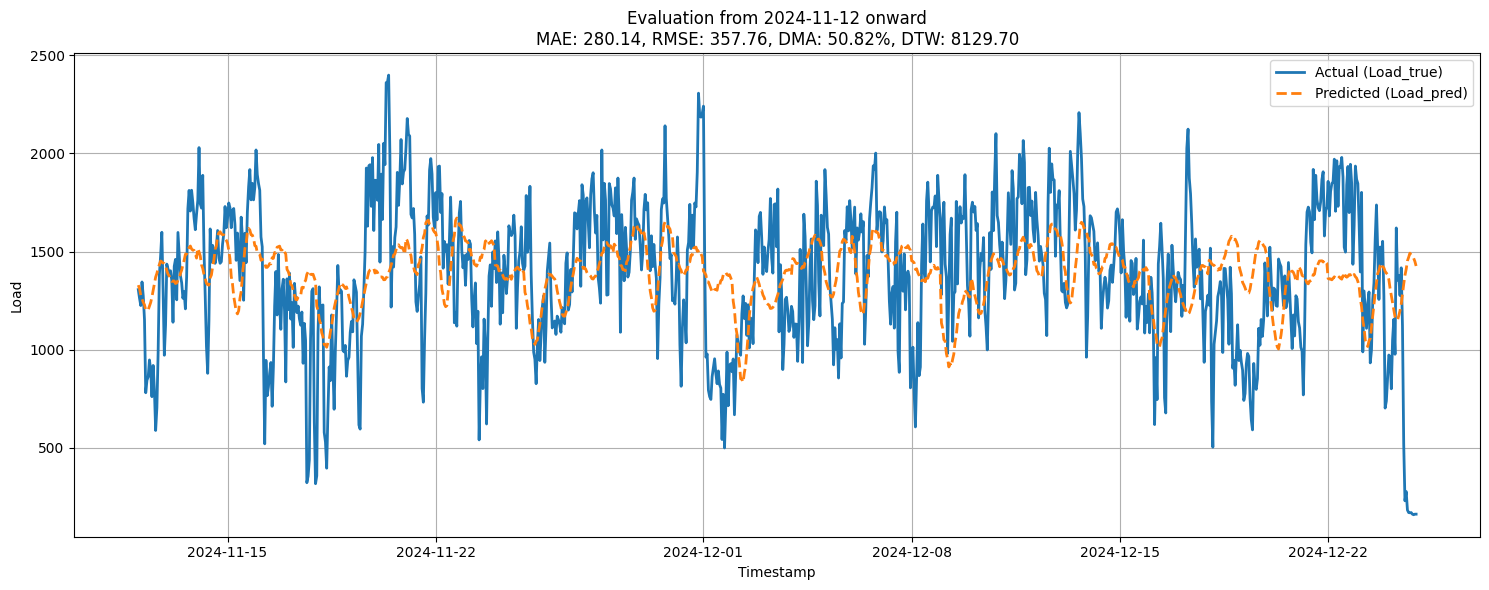

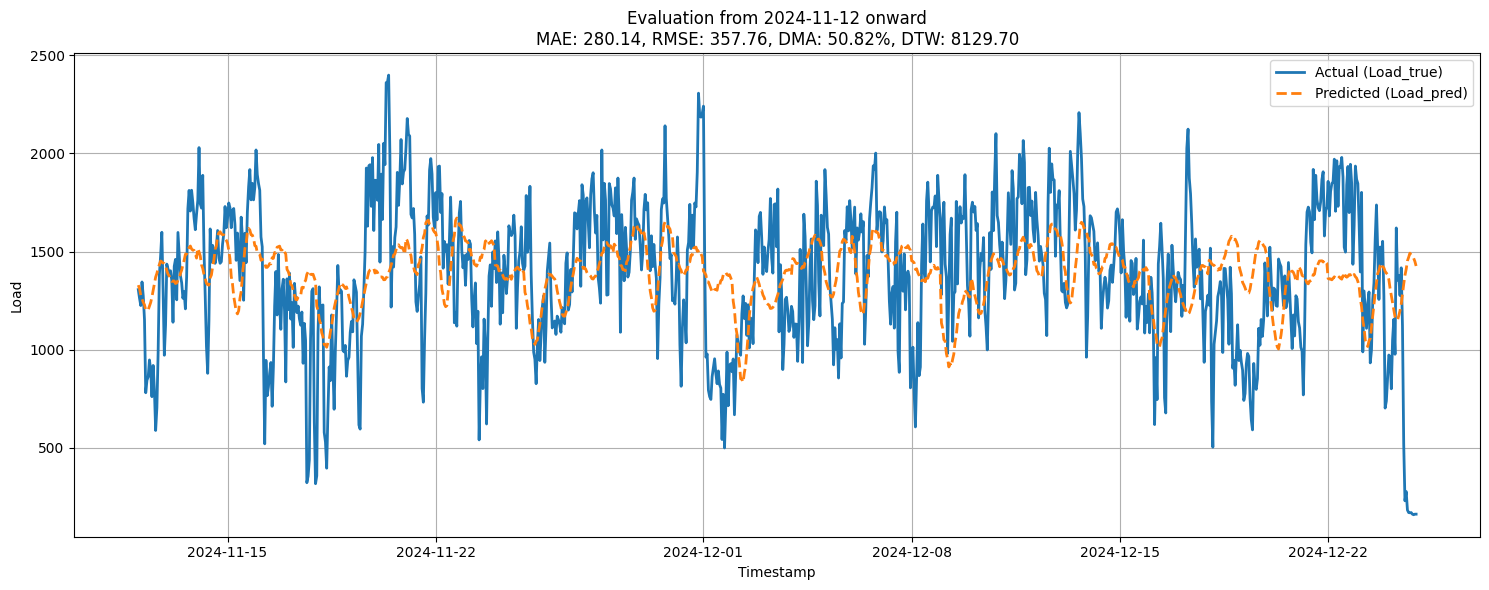

In [18]:
# Define test_start cut-off
test_start = pd.to_datetime("2024-11-12")

# Filter the forecasts to only include the test period
df_eval = df_forecasts[df_forecasts.index >= test_start]

# Extract true and predicted values
y_true = df_eval['Load_true'].values
y_pred = df_eval['Load_pred'].values

# Compute evaluation metrics
mae_real = mean_absolute_error(y_true, y_pred)
rmse_real = math.sqrt(mean_squared_error(y_true, y_pred))
dma_value = directional_mean_accuracy(y_true, y_pred)
dtw_d = dtw.distance(y_true, y_pred)

# === Results ===
print(f"\nMAE:  {mae_real:.3f}")
print(f"RMSE: {rmse_real:.3f}")
print(f"DMA:  {dma_value:.2f}%")
print(f"DTW:  {dtw_d:.3f}")


import matplotlib.pyplot as plt

# === Visual check: Plot forecast vs actual for evaluation period ===
plt.figure(figsize=(15, 6))
plt.plot(df_eval.index, y_true, label='Actual (Load_true)', linewidth=2)
plt.plot(df_eval.index, y_pred, label='Predicted (Load_pred)', linestyle='--', linewidth=2)

plt.title(f"Evaluation from {test_start.date()} onward\nMAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}%, DTW: {dtw_d:.2f}")
plt.xlabel("Timestamp")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt

# === Visual check: Plot forecast vs actual for evaluation period ===
plt.figure(figsize=(15, 6))
plt.plot(df_eval.index, y_true, label='Actual (Load_true)', linewidth=2)
plt.plot(df_eval.index, y_pred, label='Predicted (Load_pred)', linestyle='--', linewidth=2)

plt.title(f"Evaluation from {test_start.date()} onward\nMAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}%, DTW: {dtw_d:.2f}")
plt.xlabel("Timestamp")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



MAE:  272.089
RMSE: 340.619
DMA:  52.76%
DTW:  6915.943


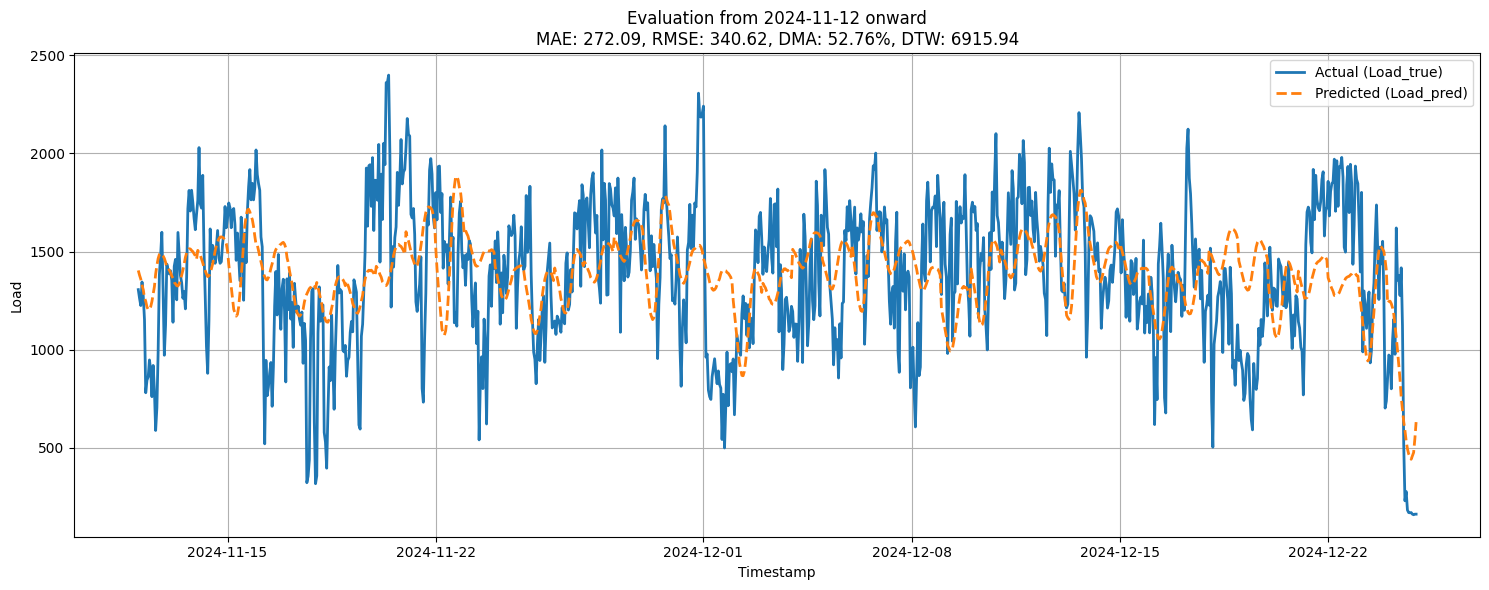

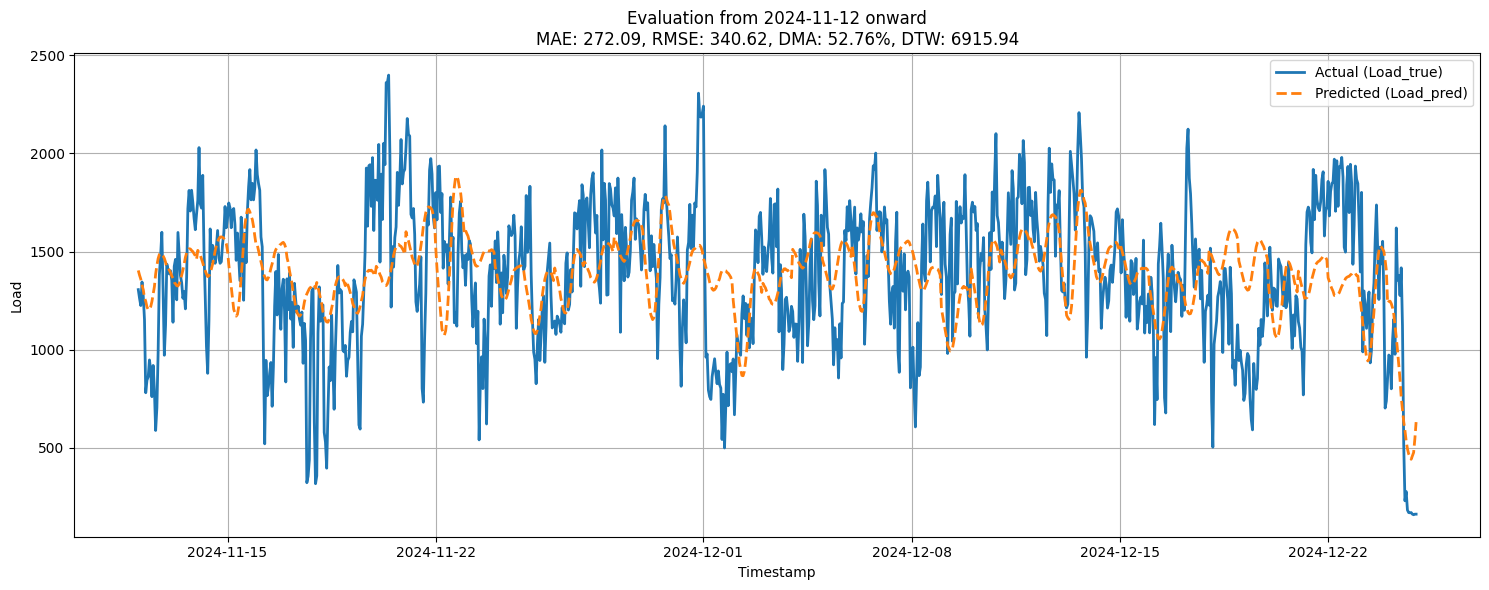

In [15]:
# Define test_start cut-off
test_start = pd.to_datetime("2024-11-12")

# Filter the forecasts to only include the test period
df_eval = df_forecasts[df_forecasts.index >= test_start]

# Extract true and predicted values
y_true = df_eval['Load_true'].values
y_pred = df_eval['Load_pred'].values

# Compute evaluation metrics
mae_real = mean_absolute_error(y_true, y_pred)
rmse_real = math.sqrt(mean_squared_error(y_true, y_pred))
dma_value = directional_mean_accuracy(y_true, y_pred)
dtw_d = dtw.distance(y_true, y_pred)

# === Results ===
print(f"\nMAE:  {mae_real:.3f}")
print(f"RMSE: {rmse_real:.3f}")
print(f"DMA:  {dma_value:.2f}%")
print(f"DTW:  {dtw_d:.3f}")


import matplotlib.pyplot as plt

# === Visual check: Plot forecast vs actual for evaluation period ===
plt.figure(figsize=(15, 6))
plt.plot(df_eval.index, y_true, label='Actual (Load_true)', linewidth=2)
plt.plot(df_eval.index, y_pred, label='Predicted (Load_pred)', linestyle='--', linewidth=2)

plt.title(f"Evaluation from {test_start.date()} onward\nMAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}%, DTW: {dtw_d:.2f}")
plt.xlabel("Timestamp")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt

# === Visual check: Plot forecast vs actual for evaluation period ===
plt.figure(figsize=(15, 6))
plt.plot(df_eval.index, y_true, label='Actual (Load_true)', linewidth=2)
plt.plot(df_eval.index, y_pred, label='Predicted (Load_pred)', linestyle='--', linewidth=2)

plt.title(f"Evaluation from {test_start.date()} onward\nMAE: {mae_real:.2f}, RMSE: {rmse_real:.2f}, DMA: {dma_value:.2f}%, DTW: {dtw_d:.2f}")
plt.xlabel("Timestamp")
plt.ylabel("Load")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_csv['Exogenous_5_shifted_24']

,Exogenous_5_shifted_24
datetime,
2023-01-15 00:00:00,0.0
2023-01-15 01:00:00,0.0
2023-01-15 02:00:00,0.0
2023-01-15 03:00:00,0.0
2023-01-15 04:00:00,0.0
...,...
2024-12-24 19:00:00,1.0
2024-12-24 20:00:00,1.0
2024-12-24 21:00:00,1.0


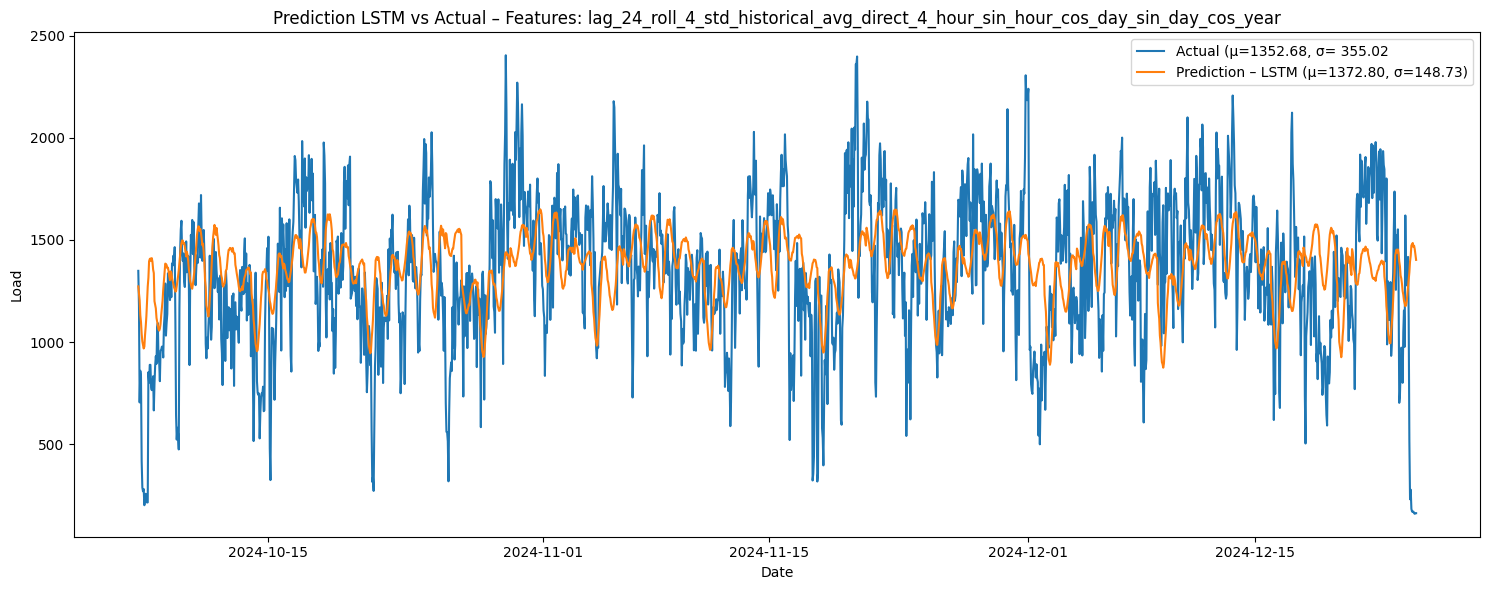

                     Actual   Prediction
timestamp                               
2024-10-07 00:00:00  1349.0  1272.776123
2024-10-07 01:00:00  1177.0  1240.164917
2024-10-07 02:00:00   705.0  1205.204102
2024-10-07 03:00:00   860.0  1131.378662
2024-10-07 04:00:00   829.0  1097.696899


In [ ]:
        # Compute statistics
actual_mean = y_true.mean()
actual_std  = y_true.std()
preds_mean  = y_pred.mean()
preds_std   = y_pred.std()

    # 6) plot Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(test_df.index,test_df['Load'].values, label=f"Actual (μ={actual_mean:.2f}, σ= 355.02")
plt.plot(df_forecasts.index,df_forecasts['Load_pred'], label=f"Prediction – LSTM (μ={preds_mean:.2f}, σ={preds_std:.2f})")
plt.title(f"Prediction LSTM vs Actual – Features: {feat_str}")
plt.xlabel("Date")
plt.ylabel("Load")
plt.legend()
plt.tight_layout()
plot_path_real     = os.path.join(PLOTS_DIR,      f"plot_{feat_str}_real_1fout.png")
plt.savefig(plot_path_real)
plt.show()

# # --- Build results DataFrame ---
# df_results = pd.DataFrame({
#     'Actual':     y_true,
#     'Prediction': y_pred
# }, index=df_forecasts.index)

# # --- Save to disk ---
# # CSV (easiest to inspect/edit in Python or Excel):
# csv_path = f"results_LSTM{'_'.join(combo)}.csv"
# df_results.to_csv(csv_path)
# print(f"✅ Saved results to {csv_path}")

# # Excel (if you need multiple sheets later):
# excel_path = f"results_LSTM{'_'.join(combo)}.xlsx"
# df_results.to_excel(excel_path, sheet_name='Pred_vs_Actual')
# print(f"✅ Saved results to {excel_path}")

# assume df_forecasts is your concatenated DataFrame with index=timestamp
# and columns ['Load_true','Load_pred']

# 1) Create the results DataFrame with the desired column names
df_results = df_forecasts[['Load_true','Load_pred']].copy()
df_results.columns = ['Actual','Prediction']

# now df_results has:
#   – a DatetimeIndex
#   – two columns: 'Actual' and 'Prediction'
print(df_results.head())

# 2) (Optional) save to CSV or Excel for later use
df_results.to_csv(f"results_LSTM{'_'.join(combo)}.csv")
df_results.to_excel(f"results_LSTM{'_'.join(combo)}.xlsx", sheet_name='Pred_vs_Actual')





In [ ]:
print("test_s index range:", test_s.index.min(), "→", test_s.index.max())
print("train_s index range:", train_s.index.min(), "→", train_s.index.max())
print("val_s index range:", val_s.index.min(), "→", val_s.index.max())

print("Forecasted hours:", df_forecasts.index[-24:])


test_s index range: 2024-09-23 00:00:00 → 2024-12-24 23:00:00
train_s index range: 2024-02-07 00:00:00 → 2024-08-06 23:00:00
val_s index range: 2024-08-07 00:00:00 → 2024-10-06 23:00:00
Forecasted hours: DatetimeIndex(['2024-12-24 00:00:00', '2024-12-24 01:00:00',
               '2024-12-24 02:00:00', '2024-12-24 03:00:00',
               '2024-12-24 04:00:00', '2024-12-24 05:00:00',
               '2024-12-24 06:00:00', '2024-12-24 07:00:00',
               '2024-12-24 08:00:00', '2024-12-24 09:00:00',
               '2024-12-24 10:00:00', '2024-12-24 11:00:00',
               '2024-12-24 12:00:00', '2024-12-24 13:00:00',
               '2024-12-24 14:00:00', '2024-12-24 15:00:00',
               '2024-12-24 16:00:00', '2024-12-24 17:00:00',
               '2024-12-24 18:00:00', '2024-12-24 19:00:00',
               '2024-12-24 20:00:00', '2024-12-24 21:00:00',
               '2024-12-24 22:00:00', '2024-12-24 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=No

In [ ]:
data_short_dubbel = data_short
data_short_dubbel

,Load,lag_24,lag_48,lag_144,lag_168,lag_312,lag_336,roll_24_mean,roll_4_mean,roll_168_std,...,roll_24_std,roll_12_std,roll_4_std,roll_168_std_direct,roll_120_std_direct,roll_48_std_direct,roll_24_std_direct,roll_12_std_direct,roll_4_std_direct,trend_last24h
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-15 00:00:00,1372.0,1608.0,1148.0,1138.0,1076.0,144.0,136.0,1052.833333,1556.00,363.257856,...,215.004685,181.322415,169.972547,326.933791,360.459157,450.416779,537.043976,697.229105,456.871244,6.866087
2023-01-15 01:00:00,1520.0,1510.0,1300.0,1364.0,1406.0,144.0,136.0,1043.000000,1515.50,363.046764,...,212.310666,170.352487,98.337853,340.742288,377.913778,477.492048,592.852975,742.843488,14.500000,5.278261
2023-01-15 02:00:00,1472.0,1642.0,1630.0,1194.0,1396.0,168.0,136.0,1043.416667,1517.50,363.412353,...,212.711668,147.828217,70.370448,354.324487,393.676672,500.224262,644.552013,764.481028,0.000000,3.962609
2023-01-15 03:00:00,1408.0,1542.0,1632.0,1186.0,1366.0,144.0,134.0,1036.333333,1501.00,363.618874,...,210.567694,133.877714,60.252248,365.823458,406.600565,523.032522,683.560542,765.286379,28.500000,7.371304
2023-01-15 04:00:00,1502.0,1438.0,1534.0,1418.0,1512.0,144.0,136.0,1030.750000,1443.00,363.700212,...,210.194044,131.718709,84.687661,366.609965,408.640890,523.893483,686.350504,710.487647,389.926916,9.791304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 19:00:00,171.0,1437.0,1847.0,906.0,1166.0,1953.0,1887.0,925.000000,200.75,399.350595,...,287.122831,231.581176,123.399082,359.622537,362.605504,377.107148,281.823102,301.600415,149.731983,-17.696087
2024-12-24 20:00:00,163.0,1552.0,1435.0,946.0,936.0,1382.0,2100.0,872.250000,174.00,408.372670,...,288.260739,236.561911,133.269151,356.797998,362.101166,381.338014,284.979938,269.039523,148.856754,-13.381304
2024-12-24 21:00:00,160.0,1274.0,1632.0,819.0,1195.0,1458.0,1683.0,814.375000,168.75,416.512409,...,286.697336,237.189398,124.938652,352.246817,360.774283,374.452941,298.486615,297.286924,289.225834,-12.038261


In [ ]:
data_short = data_short_dubbel
# data_short = data_short.loc['2024-02-07':]

# data_short  =  data.loc[:'2024-12-24']
# data_short = data_short.dropna()

# 3. Define cut‑over dates
val_start  = pd.to_datetime("2024-08-07")
test_start = pd.to_datetime("2024-10-07")

# 4. Slice into train/val/test on the truncated data
train_df = data_short.loc[: val_start - pd.Timedelta(hours=1)].copy()
val_df   = data_short.loc[val_start : test_start - pd.Timedelta(hours=1)].copy()
test_df  = data_short.loc[test_start :].copy()

print("train_df index range:", train_df.index.min(), "→", train_df.index.max())
print("val_df index range:", val_df.index.min(), "→", val_df.index.max())
print("test_df index range:", test_df.index.min(), "→", test_df.index.max())


# print("Latest base_time allowed:", test_s.index.max() - pd.Timedelta(hours=prediction_time - 1))

full_df = data_short.copy()

train_df index range: 2023-01-15 00:00:00 → 2024-08-06 23:00:00
val_df index range: 2024-08-07 00:00:00 → 2024-10-06 23:00:00
test_df index range: 2024-10-07 00:00:00 → 2024-12-24 23:00:00


In [ ]:
results_df.to_excel('results.xlsx')

PER HOUR

In [ ]:
#second version

import os
import joblib
import math
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit


# ── EDIT THIS TO YOUR LOCAL WIN PATH ────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR  = "/content/drive/MyDrive/Thesis AI - vaheeden/saved_models"
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ─────────────────────────────────────────────────────────────────────

os.makedirs(PLOTS_DIR, exist_ok=True)

# --- your create_sequences ---
def create_sequences(data, feature_cols, window_size, prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_time):
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + prediction_time]['Load'].values)
    return np.array(X), np.array(y)


def create_sequences_24_hour(data,feature_cols, window_size=168, Prediction_time=24,step=1, return_times=True):
    X, y, times = [], [], []
    for i in range(1,len(data) - window_size - Prediction_time, step):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size ][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + Prediction_time]['Load'].values)
        if return_times:
            times.append(data.index[i + window_size])   # 00:00 of day T+1
    if return_times:
        return np.array(X), np.array(y), times
    return np.array(X), np.array(y)

import plotly.graph_objects as go
import os

def save_interactive_actual_vs_pred(timestamp_index, y_true, y_pred,
                                    title, file_name,
                                    folder=PLOTS_DIR):
    """Make a Plotly figure and save it as an HTML file in Drive."""

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=timestamp_index,
        y=y_true,
        mode="lines",
        name="Actual"
    ))

    fig.add_trace(go.Scatter(
        x=timestamp_index,
        y=y_pred,
        mode="lines",
        name="Predicted",
        line=dict(dash="dash")
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title="Load",
        template="plotly_white",
        hovermode="x unified"
    )

    # make sure the output folder exists
    os.makedirs(folder, exist_ok=True)

    full_path = os.path.join(folder, file_name + ".html")
    fig.write_html(full_path)      # self-contained html
    print(f"🖼️ Interactive figure saved to {full_path}")

    return full_path





# --- LSTM builder ---
def build_lstm_model(window_size, n_features, prediction_time,
                     lstm_units=[32,16], dropout=0.2):
    m = Sequential([
        LSTM(lstm_units[0], activation='tanh', return_sequences=True,
             input_shape=(window_size, n_features)),
        Dropout(dropout),
        LSTM(lstm_units[1], activation='tanh', return_sequences=False),
        Dropout(dropout),
        Dense(prediction_time)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m


    # --- settings ---
window_size     = 168
prediction_time = 24

test_combinations=[['lag_312', 'hour', 'Day_of_week', 'year', 'roll_4_std_direct']







]
# # prepare output dirs
# os.makedirs("saved_models", exist_ok=True)
# os.makedirs("saved_models/plots", exist_ok=True)

results = []

for combo in test_combinations:
    feat_str = "_".join(combo)

    # helper to scale any df
    def scale_df(df):
        df_s = pd.DataFrame(index=df.index)
        df_s[combo] = scaler_X.transform(df[combo])
        df_s['Load'] = scaler_y.transform(df[['Load']])
        return df_s

        # 2) Set up TimeSeriesSplit
    full_df = data_short.copy()
    val_pct   = 0.10
    n         = len(full_df)
    test_size = int(n * val_pct)
    tscv      = TimeSeriesSplit(n_splits=5, test_size=test_size)

    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(full_df), 1):
      train_df = full_df.iloc[train_idx]
      val_df = full_df.iloc[val_idx]

      # 1) fit scalers
      scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(train_df[combo])
      scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(train_df[['Load']])

      train_s = scale_df(train_df)
      val_s   = scale_df(val_df)

      # 2) sequences
      X_tr, y_tr = create_sequences(train_s, combo, window_size, prediction_time)
      X_val, y_val = create_sequences(val_s, combo, window_size, prediction_time)

      tf.keras.backend.clear_session()
      # 3) build & train
      model = build_lstm_model(window_size, len(combo), prediction_time)
      es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
      model.fit(
          X_tr, y_tr,
          validation_data=(X_val, y_val),
          epochs=50, batch_size=32,
          callbacks=[es],
          shuffle=False
      )

      # 7) Evaluate on the validation fold
      y_pred_s = model.predict(X_val)
      y_va_inv      = scaler_y.inverse_transform(y_val)
      y_pred_inv    = scaler_y.inverse_transform(y_pred_s)
      mae_val       = mean_absolute_error(y_va_inv.flatten(), y_pred_inv.flatten())
      rmse_val      = math.sqrt(mean_squared_error(y_va_inv.flatten(), y_pred_inv.flatten()))
      dma_value  = directional_mean_accuracy(y_va_inv.flatten(), y_pred_inv.flatten())
      dtw_d = 1

      combo_key = tuple(combo)

      # 7) record result
      results.append({'features': combo_key, "fold": fold, 'MAE_val': mae_val, 'RMSE_val': rmse_val, 'DMA': dma_value, 'DTW': dtw_d })
      print(f"✔ [{feat_str}] saved model + plot  → fold: {fold:.3f}, MAE_val: {mae_val:.3f}, RMSE_val: {rmse_val:.3f}, DMA: {dma_value:.2f}, DTW: {dtw_d:.2f}")

# final summary
results_df = pd.DataFrame(results).sort_values('MAE_val').reset_index(drop=True)
results_df.to_excel('results_perfold_allhoours.xlsx')

# summary
summary = (
    results_df
      .groupby("features")
      .agg(MAE_val=("MAE_val","mean"),
           rmse=("RMSE_val","mean"),
           dma=("DMA","mean"),
           dtw=("DTW","mean"))
      .reset_index()
)
print(summary.sort_values("MAE_val"))
summary.to_excel("sum_allhours.xlsx", index=False)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.0979 - val_loss: 0.1531
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0881 - val_loss: 0.1503
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0850 - val_loss: 0.1483
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0838 - val_loss: 0.1480
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0827 - val_loss: 0.1469
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0819 - val_loss: 0.1455
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0810 - val_loss: 0.1453
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0807 - val_loss: 0.1455
Epoch 9/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0800 - val_loss: 0.1462
Epoch 10/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0796 - val_loss: 0.1466
Epoch 11/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0786 - val_loss: 0.1472
Epoch 12/50
261/261 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0750 - val_loss: 0.1429
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0704 - val_loss: 0.1519
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0698 - val_loss: 0.1520
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0690 - val_loss: 0.1541
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0680 - val_loss: 0.1524
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0672 - val_loss: 0.1538
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0660 - val_loss: 0.1543
Epoch 8/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0650 - val_loss: 0.1523
Epoch 9/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0637 - val_loss: 0.1551
Epoch 10/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0626 - val_loss: 0.1558
Epoch 11/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0626 - val_loss: 0.1554
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✔ [lag_312_ho

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0639 - val_loss: 0.1084
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0598 - val_loss: 0.1096
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0589 - val_loss: 0.1059
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0584 - val_loss: 0.1039
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0578 - val_loss: 0.0999
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0580 - val_loss: 0.0972
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0572 - val_loss: 0.0966
Epoch 8/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0571 - val_loss: 0.0954
Epoch 9/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0566 - val_loss: 0.0935
Epoch 10/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0563 - val_loss: 0.0944
Epoch 11/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0559 - val_loss: 0.0918
Epoch 12/50
367/367 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.0647 - val_loss: 0.0886
Epoch 2/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0616 - val_loss: 0.0831
Epoch 3/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0598 - val_loss: 0.0813
Epoch 4/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0593 - val_loss: 0.0793
Epoch 5/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0585 - val_loss: 0.0788
Epoch 6/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0579 - val_loss: 0.0782
Epoch 7/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0574 - val_loss: 0.0782
Epoch 8/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0571 - val_loss: 0.0774
Epoch 9/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0570 - val_loss: 0.0777
Epoch 10/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0564 - val_loss: 0.0773
Epoch 11/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0560 - val_loss: 0.0783
Epoch 12/50
420/420 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0669 - val_loss: 0.0788
Epoch 2/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0624 - val_loss: 0.0781
Epoch 3/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0606 - val_loss: 0.0770
Epoch 4/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0602 - val_loss: 0.0759
Epoch 5/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0594 - val_loss: 0.0755
Epoch 6/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0586 - val_loss: 0.0753
Epoch 7/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0583 - val_loss: 0.0751
Epoch 8/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0578 - val_loss: 0.0751
Epoch 9/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0576 - val_loss: 0.0748
Epoch 10/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0573 - val_loss: 0.0747
Epoch 11/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0571 - val_loss: 0.0747
Epoch 12/50
474/474 ━━━━━━━━━━━━━━━━━━━

PER 24 hour

In [ ]:
#second version

import os
import joblib
import math
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit


# ── EDIT THIS TO YOUR LOCAL WIN PATH ────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR  = "/content/drive/MyDrive/Thesis AI - vaheeden/saved_models"
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ─────────────────────────────────────────────────────────────────────

os.makedirs(PLOTS_DIR, exist_ok=True)

# --- your create_sequences ---
def create_sequences(data, feature_cols, window_size, prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_time):
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + prediction_time]['Load'].values)
    return np.array(X), np.array(y)


def create_sequences_24_hour(data,feature_cols, window_size=168, Prediction_time=24,step=1, return_times=True):
    X, y, times = [], [], []
    for i in range(1,len(data) - window_size - Prediction_time, step):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size ][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + Prediction_time]['Load'].values)
        if return_times:
            times.append(data.index[i + window_size])   # 00:00 of day T+1
    if return_times:
        return np.array(X), np.array(y), times
    return np.array(X), np.array(y)

import plotly.graph_objects as go
import os

def save_interactive_actual_vs_pred(timestamp_index, y_true, y_pred,
                                    title, file_name,
                                    folder=PLOTS_DIR):
    """Make a Plotly figure and save it as an HTML file in Drive."""

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=timestamp_index,
        y=y_true,
        mode="lines",
        name="Actual"
    ))

    fig.add_trace(go.Scatter(
        x=timestamp_index,
        y=y_pred,
        mode="lines",
        name="Predicted",
        line=dict(dash="dash")
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title="Load",
        template="plotly_white",
        hovermode="x unified"
    )

    # make sure the output folder exists
    os.makedirs(folder, exist_ok=True)

    full_path = os.path.join(folder, file_name + ".html")
    fig.write_html(full_path)      # self-contained html
    print(f"🖼️ Interactive figure saved to {full_path}")

    return full_path





# --- LSTM builder ---
def build_lstm_model(window_size, n_features, prediction_time,
                     lstm_units=[32,16], dropout=0.2):
    m = Sequential([
        LSTM(lstm_units[0], activation='tanh', return_sequences=True,
             input_shape=(window_size, n_features)),
        Dropout(dropout),
        LSTM(lstm_units[1], activation='tanh', return_sequences=False),
        Dropout(dropout),
        Dense(prediction_time)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m


    # --- settings ---
window_size     = 168
prediction_time = 24

test_combinations=[

   ['lag_312', 'hour', 'Day_of_week', 'year', 'roll_4_std_direct']








]
# # prepare output dirs
# os.makedirs("saved_models", exist_ok=True)
# os.makedirs("saved_models/plots", exist_ok=True)

results = []

for combo in test_combinations:
    feat_str = "_".join(combo)

    # helper to scale any df
    def scale_df(df):
        df_s = pd.DataFrame(index=df.index)
        df_s[combo] = scaler_X.transform(df[combo])
        df_s['Load'] = scaler_y.transform(df[['Load']])
        return df_s

        # 2) Set up TimeSeriesSplit
    full_df = data_short.copy()
    val_pct   = 0.10
    n         = len(full_df)
    test_size = int(n * val_pct)
    tscv      = TimeSeriesSplit(n_splits=5, test_size=test_size)

    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(full_df), 1):
      train_df = full_df.iloc[train_idx]
      val_df = full_df.iloc[val_idx]

      # 1) fit scalers
      scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(train_df[combo])
      scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(train_df[['Load']])

      train_s = scale_df(train_df)
      val_s   = scale_df(val_df)

      X_tr, y_tr, t0_list = create_sequences_24_hour(train_s, combo, window_size, prediction_time, step=24, return_times=True)
      X_val, y_val, t0_list = create_sequences_24_hour(val_s, combo, window_size, prediction_time, step=24, return_times=True)

      tf.keras.backend.clear_session()
      # 3) build & train
      model = build_lstm_model(window_size, len(combo), prediction_time)
      es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
      model.fit(
          X_tr, y_tr,
          validation_data=(X_val, y_val),
          epochs=50, batch_size=32,
          callbacks=[es],
          shuffle=False
      )

      # 7) Evaluate on the validation fold
      y_pred_s = model.predict(X_val)
      y_va_inv      = scaler_y.inverse_transform(y_val)
      y_pred_inv    = scaler_y.inverse_transform(y_pred_s)
      mae_val       = mean_absolute_error(y_va_inv.flatten(), y_pred_inv.flatten())
      rmse_val      = math.sqrt(mean_squared_error(y_va_inv.flatten(), y_pred_inv.flatten()))
      dma_value  = directional_mean_accuracy(y_va_inv.flatten(), y_pred_inv.flatten())
      dtw_d = dtw.distance(y_va_inv.flatten(), y_pred_inv.flatten())

      combo_key = tuple(combo)

      # 7) record result
      results.append({'features': combo_key, "fold": fold, 'MAE_val': mae_val, 'RMSE_val': rmse_val, 'DMA': dma_value, 'DTW': dtw_d })
      print(f"✔ [{feat_str}] saved model + plot  → fold: {fold:.3f}, MAE_val: {mae_val:.3f}, RMSE_val: {rmse_val:.3f}, DMA: {dma_value:.2f}, DTW: {dtw_d:.2f}")

# final summary
results_df = pd.DataFrame(results).sort_values('MAE_val').reset_index(drop=True)
results_df.to_excel('results_perfold_allhoours_2.xlsx')

# summary
summary = (
    results_df
      .groupby("features")
      .agg(MAE_val=("MAE_val","mean"),
           rmse=("RMSE_val","mean"),
           dma=("DMA","mean"),
           dtw=("DTW","mean"))
      .reset_index()
)
print(summary.sort_values("MAE_val"))
summary.to_excel("sum_allhours_2.xlsx", index=False)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.1004 - val_loss: 0.1621
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0858 - val_loss: 0.1595
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0817 - val_loss: 0.1572
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0793 - val_loss: 0.1554
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0791 - val_loss: 0.1539
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0780 - val_loss: 0.1526
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0781 - val_loss: 0.1515
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0771 - val_loss: 0.1508
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0773 - val_loss: 0.1501
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0764 - val_loss: 0.1494
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0762 - val_loss: 0.1486
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0759 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0767 - val_loss: 0.1430
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0671 - val_loss: 0.1345
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0658 - val_loss: 0.1310
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0654 - val_loss: 0.1301
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0645 - val_loss: 0.1286
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0643 - val_loss: 0.1279
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0642 - val_loss: 0.1279
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0643 - val_loss: 0.1258
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0637 - val_loss: 0.1262
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0635 - val_loss: 0.1276
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0631 - val_loss: 0.1261
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0631 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0780 - val_loss: 0.1235
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0633 - val_loss: 0.1126
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0611 - val_loss: 0.1118
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0595 - val_loss: 0.1098
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0589 - val_loss: 0.1082
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0576 - val_loss: 0.1056
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0574 - val_loss: 0.1037
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0566 - val_loss: 0.1004
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0566 - val_loss: 0.0971
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0564 - val_loss: 0.0952
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0557 - val_loss: 0.0919
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0554 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0719 - val_loss: 0.0816
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0634 - val_loss: 0.0793
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0618 - val_loss: 0.0783
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0602 - val_loss: 0.0778
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0593 - val_loss: 0.0778
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0590 - val_loss: 0.0777
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0586 - val_loss: 0.0780
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0580 - val_loss: 0.0785
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0574 - val_loss: 0.0797
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0569 - val_loss: 0.0802
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0563 - val_loss: 0.0808
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0556 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0771 - val_loss: 0.0805
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0659 - val_loss: 0.0769
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0636 - val_loss: 0.0756
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0615 - val_loss: 0.0744
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0609 - val_loss: 0.0734
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0600 - val_loss: 0.0716
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0598 - val_loss: 0.0707
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0584 - val_loss: 0.0693
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0578 - val_loss: 0.0709
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0573 - val_loss: 0.0704
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0572 - val_loss: 0.0697
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0562 - val_l

per hour en dan 24 hour check

In [ ]:
#second version

import os
import joblib
import math
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit


# ── EDIT THIS TO YOUR LOCAL WIN PATH ────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR  = "/content/drive/MyDrive/Thesis AI - vaheeden/saved_models"
MODELS_DIR = os.path.join(BASE_DIR, "models")
PLOTS_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# ─────────────────────────────────────────────────────────────────────

os.makedirs(PLOTS_DIR, exist_ok=True)

# --- your create_sequences ---
def create_sequences(data, feature_cols, window_size, prediction_time):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_time):
        X.append(data.iloc[i:i + window_size][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + prediction_time]['Load'].values)
    return np.array(X), np.array(y)


def create_sequences_24_hour(data,feature_cols, window_size=168, Prediction_time=24,step=1, return_times=True):
    X, y, times = [], [], []
    for i in range(1,len(data) - window_size - Prediction_time, step):  # Forecast next 96 steps
        X.append(data.iloc[i:i + window_size ][feature_cols].values)
        y.append(data.iloc[i + window_size:i + window_size + Prediction_time]['Load'].values)
        if return_times:
            times.append(data.index[i + window_size])   # 00:00 of day T+1
    if return_times:
        return np.array(X), np.array(y), times
    return np.array(X), np.array(y)

import plotly.graph_objects as go
import os

def save_interactive_actual_vs_pred(timestamp_index, y_true, y_pred,
                                    title, file_name,
                                    folder=PLOTS_DIR):
    """Make a Plotly figure and save it as an HTML file in Drive."""

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=timestamp_index,
        y=y_true,
        mode="lines",
        name="Actual"
    ))

    fig.add_trace(go.Scatter(
        x=timestamp_index,
        y=y_pred,
        mode="lines",
        name="Predicted",
        line=dict(dash="dash")
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title="Load",
        template="plotly_white",
        hovermode="x unified"
    )

    # make sure the output folder exists
    os.makedirs(folder, exist_ok=True)

    full_path = os.path.join(folder, file_name + ".html")
    fig.write_html(full_path)      # self-contained html
    print(f"🖼️ Interactive figure saved to {full_path}")

    return full_path





# --- LSTM builder ---
def build_lstm_model(window_size, n_features, prediction_time,
                     lstm_units=[32,16], dropout=0.2):
    m = Sequential([
        LSTM(lstm_units[0], activation='tanh', return_sequences=True,
             input_shape=(window_size, n_features)),
        Dropout(dropout),
        LSTM(lstm_units[1], activation='tanh', return_sequences=False),
        Dropout(dropout),
        Dense(prediction_time)
    ])
    m.compile(optimizer='adam', loss='mse')
    return m


    # --- settings ---
window_size     = 168
prediction_time = 24

test_combinations=[

['lag_312', 'hour', 'Day_of_week', 'year', 'roll_4_std_direct']








]
# # prepare output dirs
# os.makedirs("saved_models", exist_ok=True)
# os.makedirs("saved_models/plots", exist_ok=True)

results = []

for combo in test_combinations:
    feat_str = "_".join(combo)

    # helper to scale any df
    def scale_df(df):
        df_s = pd.DataFrame(index=df.index)
        df_s[combo] = scaler_X.transform(df[combo])
        df_s['Load'] = scaler_y.transform(df[['Load']])
        return df_s

        # 2) Set up TimeSeriesSplit
    full_df = data_short.copy()
    val_pct   = 0.10
    n         = len(full_df)
    test_size = int(n * val_pct)
    tscv      = TimeSeriesSplit(n_splits=5, test_size=test_size)

    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(full_df), 1):
      train_df = full_df.iloc[train_idx]
      val_df = full_df.iloc[val_idx]

      # 1) fit scalers
      scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(train_df[combo])
      scaler_y = MinMaxScaler(feature_range=(-1, 1)).fit(train_df[['Load']])

      train_s = scale_df(train_df)
      val_s   = scale_df(val_df)

      # 2) sequences
      X_tr, y_tr = create_sequences(train_s, combo, window_size, prediction_time)
      X_val, y_val = create_sequences(val_s, combo, window_size, prediction_time)

      tf.keras.backend.clear_session()
      # 3) build & train
      model = build_lstm_model(window_size, len(combo), prediction_time)
      es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
      model.fit(
          X_tr, y_tr,
          validation_data=(X_val, y_val),
          epochs=50, batch_size=32,
          callbacks=[es],
          shuffle=False
      )

      # 7) Evaluate on the validation fold
      y_pred_s = model.predict(X_val)
      y_va_inv      = scaler_y.inverse_transform(y_val)
      y_pred_inv    = scaler_y.inverse_transform(y_pred_s)
      mae_val       = mean_absolute_error(y_va_inv.flatten(), y_pred_inv.flatten())
      rmse_val      = math.sqrt(mean_squared_error(y_va_inv.flatten(), y_pred_inv.flatten()))

      # 24 hour plot (more correct)
      X_test, y_test, t0_list = create_sequences_24_hour(val_s, combo, window_size, prediction_time, step=24, return_times=True)
      y_pred_scaled_2 = model.predict(X_test)
      y_pred        = scaler_y.inverse_transform(y_pred_scaled_2)
      y_true        = scaler_y.inverse_transform(y_test)
      # Compute evaluation metrics
      mae_real = mean_absolute_error(y_true.flatten(), y_pred.flatten())
      rmse_real = math.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
      dma_value  = directional_mean_accuracy(y_true.flatten(), y_pred.flatten())
      dtw_d = dtw.distance(y_true.flatten(), y_pred.flatten())

      combo_key = tuple(combo)

      # 7) record result
      results.append({'features': combo_key, "fold": fold, 'MAE_val': mae_real, 'RMSE_val': rmse_real, 'DMA': dma_value, 'DTW': dtw_d })
      print(f"✔ [{feat_str}] saved model + plot  → fold: {fold:.3f}, MAE_val: {mae_real:.3f}, RMSE_val: {rmse_real:.3f}, DMA: {dma_value:.2f}, DTW: {dtw_d:.2f}")

# final summary
results_df = pd.DataFrame(results).sort_values('MAE_val').reset_index(drop=True)
results_df.to_excel('results_perfold_allhoours_3.xlsx')

# summary
summary = (
    results_df
      .groupby("features")
      .agg(MAE_val=("MAE_val","mean"),
           rmse=("RMSE_val","mean"),
           dma=("DMA","mean"),
           dtw=("DTW","mean"))
      .reset_index()
)
print(summary.sort_values("MAE_val"))
summary.to_excel("sum_allhours_3.xlsx", index=False)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0984 - val_loss: 0.1575
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0880 - val_loss: 0.1564
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0854 - val_loss: 0.1551
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0841 - val_loss: 0.1528
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0834 - val_loss: 0.1521
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0828 - val_loss: 0.1524
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0823 - val_loss: 0.1544
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0820 - val_loss: 0.1598
Epoch 9/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0812 - val_loss: 0.1674
Epoch 10/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0809 - val_loss: 0.1784
Epoch 11/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0800 - val_loss: 0.1770
Epoch 12/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0723 - val_loss: 0.1413
Epoch 2/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0697 - val_loss: 0.1528
Epoch 3/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0691 - val_loss: 0.1513
Epoch 4/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0683 - val_loss: 0.1536
Epoch 5/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0678 - val_loss: 0.1523
Epoch 6/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0668 - val_loss: 0.1540
Epoch 7/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0652 - val_loss: 0.1544
Epoch 8/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0649 - val_loss: 0.1538
Epoch 9/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0633 - val_loss: 0.1526
Epoch 10/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0631 - val_loss: 0.1534
Epoch 11/50
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0629 - val_loss: 0.1520
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
2/2 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0638 - val_loss: 0.1098
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0606 - val_loss: 0.1132
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0591 - val_loss: 0.1109
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0585 - val_loss: 0.1021
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0583 - val_loss: 0.1002
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0575 - val_loss: 0.0959
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0571 - val_loss: 0.0964
Epoch 8/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0565 - val_loss: 0.0961
Epoch 9/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0564 - val_loss: 0.0961
Epoch 10/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0555 - val_loss: 0.0938
Epoch 11/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0551 - val_loss: 0.0949
Epoch 12/50
367/367 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0638 - val_loss: 0.0869
Epoch 2/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0611 - val_loss: 0.0834
Epoch 3/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0599 - val_loss: 0.0822
Epoch 4/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0593 - val_loss: 0.0795
Epoch 5/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0586 - val_loss: 0.0789
Epoch 6/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0582 - val_loss: 0.0785
Epoch 7/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0581 - val_loss: 0.0786
Epoch 8/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0578 - val_loss: 0.0787
Epoch 9/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0574 - val_loss: 0.0786
Epoch 10/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0572 - val_loss: 0.0789
Epoch 11/50
420/420 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0569 - val_loss: 0.0785
Epoch 12/50
420/420 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0651 - val_loss: 0.0781
Epoch 2/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0610 - val_loss: 0.0780
Epoch 3/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0600 - val_loss: 0.0774
Epoch 4/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0596 - val_loss: 0.0769
Epoch 5/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0595 - val_loss: 0.0765
Epoch 6/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0586 - val_loss: 0.0753
Epoch 7/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0584 - val_loss: 0.0749
Epoch 8/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0580 - val_loss: 0.0748
Epoch 9/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0577 - val_loss: 0.0747
Epoch 10/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0572 - val_loss: 0.0743
Epoch 11/50
474/474 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0567 - val_loss: 0.0747
Epoch 12/50
474/474 ━━━━━━━━━━━━━━━━━

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18413 entries, 2023-01-01 00:00:00 to 2025-02-06 04:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   18413 non-null  float64
dtypes: float64(1)
memory usage: 287.7 KB
None
                     Price
datetime                  
2023-01-01 00:00:00  136.0
2023-01-01 01:00:00  136.0
2023-01-01 02:00:00  136.0
2023-01-01 03:00:00  134.0
2023-01-01 04:00:00  136.0


<ipython-input-77-91bcd664ff8f>:111: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['trend_prev_day'] = data['trend_prev_day'].fillna(0)
<ipython-input-77-91bcd664ff8f>:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_short['hourly_cluster_label_short'] = pd.Series(data_short.index.date, index=data_short.index).map(cluster_map_short)
<ipython-input-77-91bcd664ff8f>:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

['Load', 'lag_24', 'lag_48', 'lag_144', 'lag_168', 'lag_312', 'lag_336', 'roll_24_mean', 'roll_4_mean', 'roll_168_std', 'hour', 'Day_of_week', 'Day_of_year', 'month', 'year', 'week_of_year', 'season', 'is_weekend', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'Holidays', 'lag_38', 'historical_avg_4', 'historical_avg_24', 'historical_avg_48', 'historical_avg_120', 'historical_avg_168', 'historical_avg_direct_4', 'historical_avg_direct_24', 'historical_avg_direct_48', 'historical_avg_direct_120', 'historical_avg_direct_168', 'trend_prev_day', 'avg_last_4h', 'trend_last4h', 'trend_last48h', 'Relation_Hour_Weekday', 'date', 'hourly_cluster_label', 'hourly_cluster_label_shift_168', 'shift_1', 'shift_2', 'hourly_cluster_label_short', 'hourly_cluster_label_shift_short_168', 'hourly_cluster_label_shift_short_48', 'hourly_cluster_label_shift_short_336', 'temperature', 'temperature_lag48', 'temperature_lag54']


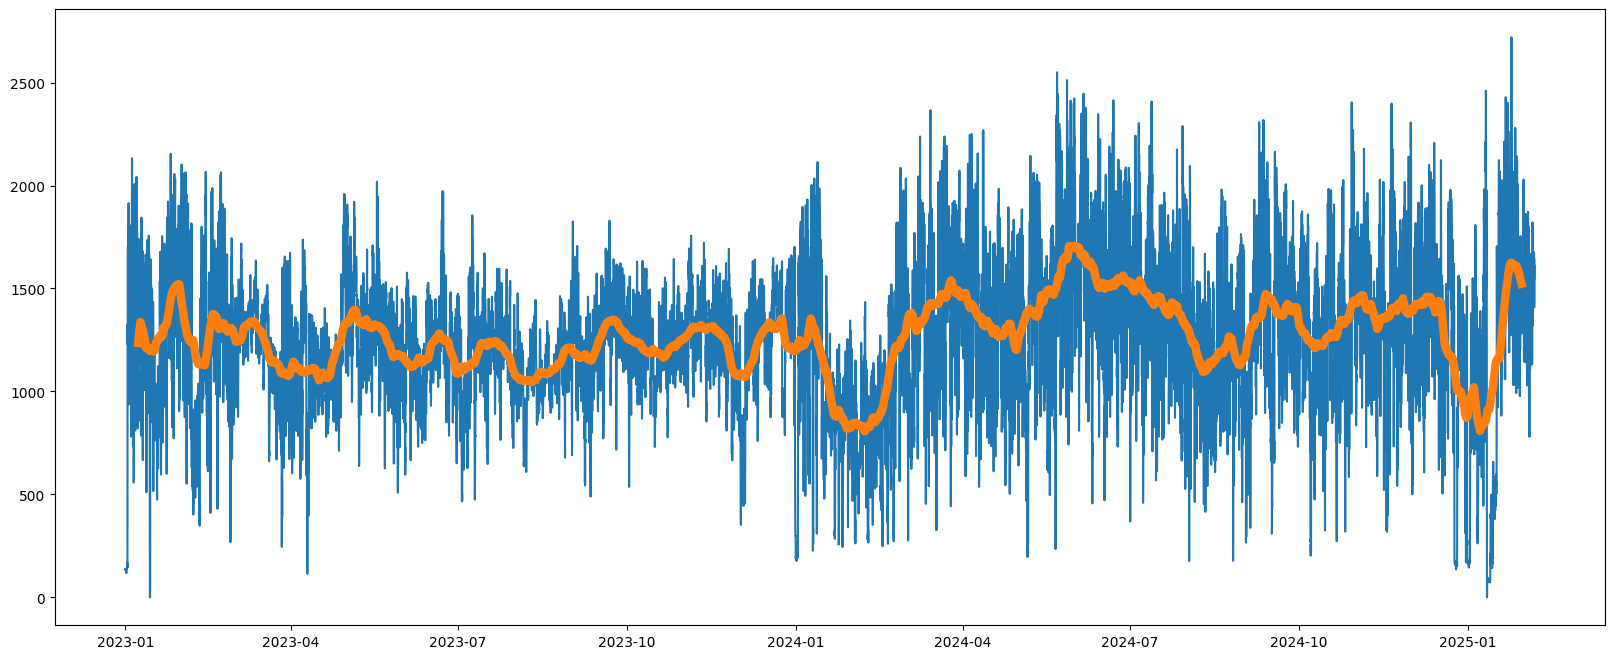

In [ ]:
import holidays

#############################################
# 1. Load and Prepare Data
#############################################

# Load data
df = pd.read_csv('combined_power_data_dottenijs_hourly.csv')

# Convert to datetime and set index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.rename(columns={'Power_Consumption_dottenijs_23-24': 'power'}, inplace=True)
# Check data summary
print(df.info())
print(df.head())

data = df.reset_index()
data = data.set_index('datetime')

data.rename(columns={'Price': 'Load'}, inplace=True)
plt.plot(data.Load)
plt.plot(data.Load.rolling(337,center=True).mean(), lw=6)


#FEATURE  - Time-based features

for lag in [24, 48, 144,168,312,336]:
    data[f"lag_{lag}"] = data["Load"].shift(lag)


data["roll_24_mean"]   = data["Load"].shift(1).rolling(24).mean()
data["roll_4_mean"]   = data["Load"].shift(1).rolling(4).mean()
data["roll_168_std"]   = data["Load"].shift(1).rolling(168).std()

data['hour'] = data.index.hour
data['Day_of_week'] = data.index.dayofweek
data['Day_of_year'] = data.index.dayofyear
data['month'] = data.index.month
data['year'] = data.index.year
data['week_of_year'] = data.index.isocalendar().week.astype(int)
data['season'] = data.index.month.map(lambda m: 2 if m in [12,1,2]
                                                   else 3 if m in [3,4,5]
                                                   else 0 if m in [6,7,8]
                                                   else 1)
data["is_weekend"] = data["Day_of_week"].isin([5,6]).astype(int)

# Encode as cyclical features
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

data['day_sin'] = np.sin(2 * np.pi * data['Day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['Day_of_week'] / 7)

data['Holidays'] = pd.Series(data.index).apply(lambda x: holidays.CountryHoliday('BE').get(x)).values
data['Holidays'] = data['Holidays'].astype('bool').astype('int')



#FEATURES  -  Lag & historical load features

data['lag_38'] = data['Load'].shift(38)
data['lag_48'] = data['Load'].shift(48)
data['lag_168'] = data['Load'].shift(168)
data['lag_336'] = data['Load'].shift(336)

# This uses data from t-168 to t-48; adjust window as needed:
data['historical_avg_4'] = data['Load'].shift(48).rolling(window=4, min_periods=1).mean()
data['historical_avg_24'] = data['Load'].shift(48).rolling(window=24, min_periods=1).mean()
data['historical_avg_48'] = data['Load'].shift(48).rolling(window=48, min_periods=1).mean()
data['historical_avg_120'] = data['Load'].shift(48).rolling(window=120, min_periods=1).mean()
data['historical_avg_168'] = data['Load'].shift(48).rolling(window=168, min_periods=1).mean()

data['historical_avg_direct_4'] = data['Load'].shift(38).rolling(window=4, min_periods=1).mean()
data['historical_avg_direct_24'] = data['Load'].shift(38).rolling(window=24, min_periods=1).mean()
data['historical_avg_direct_48'] = data['Load'].shift(38).rolling(window=48, min_periods=1).mean()
data['historical_avg_direct_120'] = data['Load'].shift(38).rolling(window=120, min_periods=1).mean()
data['historical_avg_direct_168'] = data['Load'].shift(38).rolling(window=168, min_periods=1).mean()



# FEATURES -  Trend features

from scipy.stats import linregress

# Initialize the trend column
data['trend_prev_day'] = None

# Group by day
grouped = data.groupby(data.index.date)

# Convert to list of (date, group)
groups = list(grouped)

# Start from second day (so we can use the previous one)
for i in range(1, len(groups)):
    prev_date, prev_group = groups[i - 1]
    curr_date, curr_group = groups[i]

    # Get values between 1 AM and 9 AM (exclusive) from prev day
    morning_values = prev_group.between_time("01:00", "09:00")['Load']

    if len(morning_values) >= 2:  # minimum for linregress
        x = range(len(morning_values))
        y = morning_values.values
        slope, *_ = linregress(x, y)

        # Assign same slope to all 24 hours of current day
        data.loc[data.index.date == curr_date, 'trend_prev_day'] = slope

data['trend_prev_day'] = data['trend_prev_day'].fillna(0)


        # Avg + trend of previous 4 hours
trend_4h = []
avg_4h = []
values = data['Load'].values
for i in range(len(df)):
    if i >= 42:
        window = values[i-42:i-38]
        avg = window.mean()
        # Compute trend (slope)
        slope, _, _, _, _ = linregress(range(4), window)
    else:
        avg = None
        slope = None
    avg_4h.append(avg)
    trend_4h.append(slope)
data['avg_last_4h'] = avg_4h
data['trend_last4h'] = trend_4h

      # Avg + trend of previous 48 hours
trend_48h = []
values = data['Load'].values
for i in range(len(df)):
    if i >= 86:
        window = values[i-86:i-38]
        # Compute trend (slope)
        slope, _, _, _, _ = linregress(range(48), window)
    else:
        avg = None
        slope = None
    trend_48h.append(slope)
data['trend_last48h'] = trend_48h




train_cutoff = pd.to_datetime('2024-10-07')
cluster_data = data.loc[data.index < train_cutoff].copy()

# Create unique identifier per hour of week (0 to 167)
cluster_data['hour_of_week'] = cluster_data['Day_of_week'] * 24 + cluster_data['hour']
# Median load for each (hour, day_of_week)
group_stats = cluster_data.groupby(['Day_of_week', 'hour'])['Load'].median().reset_index()
from sklearn.cluster import KMeans

# You can cluster based on median Load or add more dimensions later
kmeans = KMeans(n_clusters=3, random_state=42)
group_stats['hour_day_cluster'] = kmeans.fit_predict(group_stats[['Load']])

# Invert cluster labels: 0 → 2, 2 → 0 (leave 1 as is)
label_map = {0: 2, 2: 0, 1: 1}  # works for n_clusters=3
group_stats['hour_day_cluster'] = group_stats['hour_day_cluster'].map(label_map)

# Create mapping from (day, hour) → cluster
mapping = group_stats.set_index(['Day_of_week', 'hour'])['hour_day_cluster'].to_dict()

data['Relation_Hour_Weekday'] = data.apply(
        lambda row: mapping.get((row['Day_of_week'], row['hour'])), axis=1
    )


# Reshape to daily-hourly matrix
data['date'] = data.index.date
hourly_matrix_base = data.pivot_table(index='date', columns='hour', values='Load')
hourly_matrix = hourly_matrix_base.copy().dropna()

# Apply clustering
kmeans = KMeans(n_clusters=2, random_state=42)
hourly_matrix['cluster'] = kmeans.fit_predict(hourly_matrix)

# Map cluster labels back to timestamps
cluster_map = hourly_matrix['cluster']
data['hourly_cluster_label'] = pd.Series(data.index.date, index=data.index).map(cluster_map)
data['hourly_cluster_label_shift_168'] = data['hourly_cluster_label'].shift(168)
# data_short = data_short.dropna()


# Assign binary shift indicators directly
data['shift_1'] = data['hour'].apply(lambda h: int(13 <= h < 21))
data['shift_2'] = data['hour'].apply(lambda h: int(h >= 21 or h < 5))





# CUT VAN 2024

data_short  =  data.loc[:'2024-12-24']

hourly_matrix_base_short = data_short.pivot_table(index='date', columns='hour', values='Load')
hourly_matrix_short = hourly_matrix_base_short.copy()

# Apply clustering
kmeans = KMeans(n_clusters=2, random_state=42)
hourly_matrix_short['cluster'] = kmeans.fit_predict(hourly_matrix_short)

# Map cluster labels back to timestamps
cluster_map_short = hourly_matrix_short['cluster']
data_short['hourly_cluster_label_short'] = pd.Series(data_short.index.date, index=data_short.index).map(cluster_map_short)
data_short['hourly_cluster_label_shift_short_168'] = data_short['hourly_cluster_label_short'].shift(168)
data_short['hourly_cluster_label_shift_short_48'] = data_short['hourly_cluster_label_short'].shift(48)
data_short['hourly_cluster_label_shift_short_336'] = data_short['hourly_cluster_label_short'].shift(336)


# data_short = data_short.dropna()


df_temp = pd.read_csv('BEITEM_temp_data_updated_final (2).csv')
df_temp.rename(columns={'timestamp': 'datetime'}, inplace=True)
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
df_temp.set_index('datetime', inplace=True)
df_temperature = df_temp['temp_grass_pt100_avg'].copy()
df_temperature
# FEATURES - Exogenous feature

data_short['temperature'] = df_temperature.reindex(data_short.index)
data_short['temperature_lag48'] = data_short['temperature'].shift(48)
data_short['temperature_lag54'] = data_short['temperature'].shift(54)

data_short

# Check result
# load = TimeSeries.from_dataframe(data_short, value_cols=['Load'])
# # # Define specific train and test periods
# load_train, load_test = load.split_before(pd.to_datetime('2024-10-7'))

features = data_short.columns.tolist()
print(features)

In [ ]:
# refresh = data
refresh

,Load,lag_24,lag_48,lag_144,lag_168,lag_312,lag_336,roll_24_mean,roll_4_mean,roll_168_std,...,trend_prev_day,avg_last_4h,trend_last4h,trend_last48h,Relation_Hour_Weekday,date,hourly_cluster_label,hourly_cluster_label_shift_168,shift_1,shift_2
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,2,2023-01-01,0.0,NaN,0,1
2023-01-01 01:00:00,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,2,2023-01-01,0.0,NaN,0,1
2023-01-01 02:00:00,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,2,2023-01-01,0.0,NaN,0,1
2023-01-01 03:00:00,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,2,2023-01-01,0.0,NaN,0,1
2023-01-01 04:00:00,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.50,NaN,...,0.000000,NaN,NaN,NaN,2,2023-01-01,0.0,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-06 00:00:00,1544.0,1511.0,1378.0,1408.0,1520.0,1810.0,2263.0,1541.125000,1582.25,199.235150,...,-3.166667,1416.25,11.3,-3.165599,2,2025-02-06,NaN,1.0,0,1
2025-02-06 01:00:00,1614.0,1456.0,1388.0,1499.0,1478.0,2018.0,1980.0,1542.500000,1553.00,199.281648,...,-3.166667,1417.75,140.9,-3.611051,2,2025-02-06,NaN,1.0,0,1
2025-02-06 02:00:00,1408.0,1318.0,1272.0,1468.0,1531.0,1751.0,1741.0,1549.083333,1565.75,199.600119,...,-3.166667,1493.50,46.4,-4.111431,2,2025-02-06,NaN,1.0,0,1


In [ ]:

data = refresh.copy()
data["roll_168_std"]   = data["Load"].shift(24).rolling(168).std()
data["roll_120_std"]   = data["Load"].shift(24).rolling(120).std()
data["roll_48_std"]   = data["Load"].shift(24).rolling(48).std()
data["roll_24_std"]   = data["Load"].shift(24).rolling(24).std()
data["roll_12_std"]   = data["Load"].shift(24).rolling(12).std()
data["roll_4_std"]   = data["Load"].shift(24).rolling(4).std()

data["roll_168_std_direct"]   = data["Load"].shift(14).rolling(168).std()
data["roll_120_std_direct"]   = data["Load"].shift(14).rolling(120).std()
data["roll_48_std_direct"]   = data["Load"].shift(14).rolling(48).std()
data["roll_24_std_direct"]   = data["Load"].shift(14).rolling(24).std()
data["roll_12_std_direct"]   = data["Load"].shift(14).rolling(12).std()
data["roll_4_std_direct"]   = data["Load"].shift(14).rolling(4).std()



# This uses data from t-168 to t-48; adjust window as needed:
data['historical_avg_4'] = data['Load'].shift(24).rolling(window=4, min_periods=1).mean()
data['historical_avg_24'] = data['Load'].shift(24).rolling(window=24, min_periods=1).mean()
data['historical_avg_48'] = data['Load'].shift(24).rolling(window=48, min_periods=1).mean()
data['historical_avg_120'] = data['Load'].shift(24).rolling(window=120, min_periods=1).mean()
data['historical_avg_168'] = data['Load'].shift(24).rolling(window=168, min_periods=1).mean()

data['historical_avg_direct_4'] = data['Load'].shift(14).rolling(window=4, min_periods=1).mean()
data['historical_avg_direct_24'] = data['Load'].shift(14).rolling(window=24, min_periods=1).mean()
data['historical_avg_direct_48'] = data['Load'].shift(14).rolling(window=48, min_periods=1).mean()
data['historical_avg_direct_120'] = data['Load'].shift(14).rolling(window=120, min_periods=1).mean()
data['historical_avg_direct_168'] = data['Load'].shift(14).rolling(window=168, min_periods=1).mean()


df_temp = pd.read_csv('BEITEM_temp_data_updated_final (2).csv')
df_temp.rename(columns={'timestamp': 'datetime'}, inplace=True)
df_temp['datetime'] = pd.to_datetime(df_temp['datetime'])
df_temp.set_index('datetime', inplace=True)
df_temperature = df_temp['temp_grass_pt100_avg'].copy()
df_temperature
data['temperature'] = df_temperature.reindex(data.index)
data['temperature_lag48'] = data['temperature'].shift(48)
data['temperature_lag54'] = data['temperature'].shift(54)


        # Avg + trend of previous 4 hours
trend_4h = []
avg_4h = []
values = data['Load'].values
for i in range(len(data)):
    if i >= 28:
        window = values[i-28:i-24]
        avg = window.mean()
        # Compute trend (slope)
        slope, _, _, _, _ = linregress(range(4), window)
    else:
        avg = None
        slope = None
    avg_4h.append(avg)
    trend_4h.append(slope)
data['avg_last_4h'] = avg_4h
data['trend_last4h'] = trend_4h

      # Avg + trend of previous 48 hours
trend_48h = []
values = data['Load'].values
for i in range(len(data)):
    if i >= 72:
        window = values[i-72:i-24]
        # Compute trend (slope)
        slope, _, _, _, _ = linregress(range(48), window)
    else:
        avg = None
        slope = None
    trend_48h.append(slope)
data['trend_last48h'] = trend_48h


      # Avg + trend of previous 48 hours
trend_24h = []
values = data['Load'].values
for i in range(len(data)):
    if i >= 48:
        window = values[i-48:i-24]
        # Compute trend (slope)
        slope, _, _, _, _ = linregress(range(24), window)
    else:
        avg = None
        slope = None
    trend_24h.append(slope)
data['trend_last24h'] = trend_24h


# 1) Cyclic hour
data.index = pd.DatetimeIndex(data.index)
data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)

# 2) One-hot day-of-week
dow_dummies = pd.get_dummies(data['Day_of_week'], prefix='dow')
data = data.join(dow_dummies)





# ----//--- ON AND OFF as one-hot features

# recognition window length
k = 1

# your thresholds
offset_value_min    = 100
offset_value_medium = 400

# rolling min/max over the last k+1 timestamps (including current)
rolling_max = data['Load'].rolling(window=k+1, min_periods=1).max()
rolling_min = data['Load'].rolling(window=k+1, min_periods=1).min()

# initialize the two new columns to zero
data['Exogenous 3'] = 0  #OFF
data['Exogenous 4'] = 0  #STANDBY

# OFF: unit fully inactive
data.loc[rolling_max <= offset_value_min, 'Exogenous 3'] = 1

# STANDBY: idle/slumber consumption
data.loc[
    (rolling_min > offset_value_min) &
    (rolling_max <= offset_value_medium),
    'Exogenous 4'
] = 1

# # (ON is implicit when both Off_t==0 and Standby_t==0)
# np.random.seed(42)
# # optional: add tiny noise so the columns aren’t constant if you need
# data['Exogenous 3'] += np.random.normal(0, 1e-7, size=len(df))
# data['Exogenous 4'] += np.random.normal(0, 1e-7, size=len(df))






# Slice & then drop rows where Load is missing (but keep the last hour)
data = data.loc[:end_ts].copy().dropna()



# data_short = data_short.dropna()



# # 3. Define cut‑over dates
# val_start  = pd.to_datetime("2024-08-07")
# test_start = pd.to_datetime("2024-10-07")

# # 4. Slice into train/val/test on the truncated data
# train_df = data_short.loc[: val_start - pd.Timedelta(days=1)].copy()
# val_df   = data_short.loc[val_start : test_start - pd.Timedelta(days=1)].copy()
# test_df  = data_short.loc[test_start :].copy()

# full_df = data_short.copy()


In [ ]:
# data = data.dropna()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17040 entries, 2023-01-15 00:00:00 to 2024-12-24 23:00:00
Data columns (total 68 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Load                            17040 non-null  float64
 1   lag_24                          17040 non-null  float64
 2   lag_48                          17040 non-null  float64
 3   lag_144                         17040 non-null  float64
 4   lag_168                         17040 non-null  float64
 5   lag_312                         17040 non-null  float64
 6   lag_336                         17040 non-null  float64
 7   roll_24_mean                    17040 non-null  float64
 8   roll_4_mean                     17040 non-null  float64
 9   roll_168_std                    17040 non-null  float64
 10  hour                            17040 non-null  int32  
 11  Day_of_week                     17040 non-null  int32  
 1

In [ ]:
from google.colab import files
import io
import pandas as pd

# 1) Upload any files
print("Upload your full_features CSV and/or Excel:")
uploaded = files.upload()

# 2) Load the ones that have “full_features” in their filename
df_csv = None
df_xlsx = None

for fname, content in uploaded.items():
    lname = fname.lower()
    if "full_features" in lname:
        if lname.endswith(".csv"):
            df_csv = pd.read_csv(
                io.BytesIO(content),
                index_col=0,
                parse_dates=True
            )
            print(f"Loaded CSV into df_csv from {fname}")
        elif lname.endswith((".xls", ".xlsx")):
            df_xlsx = pd.read_excel(
                io.BytesIO(content),
                sheet_name=0,
                index_col=0,
                parse_dates=True
            )
            print(f"Loaded Excel into df_xlsx from {fname}")

# 3) Now df_csv and/or df_xlsx hold your DataFrame(s)
# Example check:
if df_csv is not None:
    print("CSV shape:", df_csv.shape)
    display(df_csv.head())
if df_xlsx is not None:
    print("Excel shape:", df_xlsx.shape)
    display(df_xlsx.head())



Upload your full_features CSV and/or Excel:


Saving full_features (4).csv to full_features (4).csv
Loaded CSV into df_csv from full_features (4).csv
CSV shape: (17040, 67)


,Load,hour,Day_of_week,Day_of_year,month,year,week_of_year,season,is_weekend,hour_sin,...,dow_5,dow_6,Exogenous 3,Exogenous 4,Relation_Hour_Weekday,shift_1,shift_2,temperature,temperature_lag48,temperature_lag54
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-15 00:00:00,1372.0,0,6,15,1,2023,2,2,1,0.000000,...,0,1,0,0,2,0,1,5.42,NaN,NaN
2023-01-15 01:00:00,1520.0,1,6,15,1,2023,2,2,1,0.258819,...,0,1,0,0,2,0,1,4.78,NaN,NaN
2023-01-15 02:00:00,1472.0,2,6,15,1,2023,2,2,1,0.500000,...,0,1,0,0,2,0,1,4.09,NaN,NaN
2023-01-15 03:00:00,1408.0,3,6,15,1,2023,2,2,1,0.707107,...,0,1,0,0,2,0,1,3.64,NaN,NaN
2023-01-15 04:00:00,1502.0,4,6,15,1,2023,2,2,1,0.866025,...,0,1,0,0,2,0,1,3.55,NaN,NaN


In [ ]:
# --- compare feature sets & values between old (CSV) and new (Excel) ---

import pandas as pd

# 1) Assign your two DataFrames
old_df = data
new_df = df_csv

# 2) Find which columns are extra/missing
old_cols = set(old_df.columns)
new_cols = set(new_df.columns)

print("⚙️  Features only in NEW:")
print(sorted(new_cols - old_cols), "\n")

print("⚙️  Features only in OLD:")
print(sorted(old_cols - new_cols), "\n")

# 3) For common features, check if values match exactly
common = sorted(old_cols & new_cols)
# align on the shared datetime index
idx = old_df.index.intersection(new_df.index)
old_al = old_df.loc[idx, common]
new_al = new_df.loc[idx, common]

diff_stats = []
for col in common:
    d = new_al[col] - old_al[col]
    diff_stats.append({
        "feature": col,
        "mean_diff": d.mean(),
        "std_diff": d.std()
    })

diff_df = pd.DataFrame(diff_stats).set_index("feature")
print("📊  Difference stats for shared features:")
print(diff_df)

# 4) Quick flag for “perfect match”
perfect = diff_df[(diff_df["mean_diff"] == 0) & (diff_df["std_diff"] == 0)].index.tolist()
print(f"\n✅  {len(perfect)} features match exactly: {perfect}")


⚙️  Features only in NEW:
['avg_last24h', 'avg_last48h', 'avg_last4h', 'historical_avg_12', 'historical_avg_direct_12'] 

⚙️  Features only in OLD:
['avg_last_4h', 'date', 'hourly_cluster_label', 'hourly_cluster_label_shift_168', 'lag_38', 'trend_prev_day'] 

📊  Difference stats for shared features:
               mean_diff   std_diff
feature                            
Day_of_week     0.000000   0.000000
Day_of_year     0.000000   0.000000
Exogenous 3     0.000000   0.000000
Exogenous 4     0.000000   0.000000
Holidays        0.000000   0.000000
...                  ...        ...
trend_last24h  -0.001210   3.832754
trend_last48h  -0.001374   1.017142
trend_last4h   -0.019800  80.478037
week_of_year    0.000000   0.000000
year            0.000000   0.000000

[62 rows x 2 columns]

✅  31 features match exactly: ['Day_of_week', 'Day_of_year', 'Exogenous 3', 'Exogenous 4', 'Holidays', 'Load', 'Relation_Hour_Weekday', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'hour', 

In [ ]:
diff_df

,mean_diff,std_diff
feature,,
Day_of_week,0.000000,0.000000
Day_of_year,0.000000,0.000000
Exogenous 3,0.000000,0.000000
Exogenous 4,0.000000,0.000000
Holidays,0.000000,0.000000
...,...,...
trend_last24h,-0.001210,3.832754
trend_last48h,-0.001374,1.017142
trend_last4h,-0.019800,80.478037


In [ ]:
import pandas as pd

# 1) Align on common timestamps
common_idx = data.index.intersection(df_csv.index)

old_lag144 = data.loc[common_idx, 'historical_avg_direct_48']
new_lag144 = df_csv.loc[common_idx, 'historical_avg_direct_48']

# 2) Find where they differ (exactly)
mask = old_lag144 != new_lag144

# 3) List all mismatched times
diff_times = old_lag144.index[mask]
print(f"Total mismatches for lag_144: {mask.sum()}")

# 4) Preview the first few mismatches with values
for ts in diff_times[:10]:
    print(f"{ts}  old: {old_lag144.at[ts]}  new: {new_lag144.at[ts]}")

# 5) (Optional) If you want to allow for tiny floating‐point tolerance:
tol = 1e-6
mask_tol = (old_lag144 - new_lag144).abs() > tol
diff_times_tol = old_lag144.index[mask_tol]
print(f"\nMismatches beyond ±{tol}: {mask_tol.sum()}")
for ts in diff_times_tol[:10]:
    d = new_lag144.at[ts] - old_lag144.at[ts]
    print(f"{ts}  old: {old_lag144.at[ts]}  new: {new_lag144.at[ts]}  diff: {d}")


Total mismatches for lag_144: 733
2023-01-17 05:00:00  old: 1261.1250003178645  new: 1261.1250003178643
2023-01-17 06:00:00  old: 1256.8750003178645  new: 1256.8750003178643
2023-01-17 07:00:00  old: 1252.5000003178645  new: 1252.5000003178643
2023-01-17 09:00:00  old: 1239.8750003178645  new: 1239.8750003178643
2023-01-17 11:00:00  old: 1217.1250003178645  new: 1217.1250003178643
2023-01-17 13:00:00  old: 1187.5000003178645  new: 1187.5000003178643
2023-01-18 10:00:00  old: 1016.0000025429167  new: 1016.0000025429168
2023-01-18 11:00:00  old: 1007.1250025429167  new: 1007.1250025429168
2023-01-18 12:00:00  old: 999.3333358762501  new: 999.33333587625
2023-01-18 13:00:00  old: 987.9166692095833  new: 987.9166692095832

Mismatches beyond ±1e-06: 0
